# **Importación de bibliotecas y dataframe**

In [86]:
import pandas as pd
import numpy as np, gc
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.experimental import enable_iterative_imputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score 
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, f1_score, silhouette_score


from pycaret.classification import *
from scipy.stats import loguniform
import shap
import optuna
import joblib


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



In [2]:
#Descargamos el archivo de datos de clima
!gdown 1xFv2WH8WHgUGENovFHkIzyCJ_NxCacRr

"gdown" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [3]:
#Descargamos el archivo de datos de las ciudades de Australia
!gdown 1oxugU5Vtw1nrBHNU_gcv54-TezdkINy7

"gdown" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Datos sacados de la página **https://www.kaggle.com/datasets/amithjohn/all-cities-in-australia-dataset**

In [4]:
ruta_clima = r'weatherAUS.csv'
ruta_ciudades = r'Australia Entire Dataset.xlsx'

clima = pd.read_csv(ruta_clima)
ciudades = pd.read_excel(ruta_ciudades)

# **Contexto**

El proyecto trata sobre una serie de datos de el **clima en Australia**. En este trabajo, nuestro objetivo es **predecir si va a llover o no** el día posterior a los datos que tenemos.  




**Variables explicativas:**  
* `Date`: La fecha de la observación.
* `Location`: El nombre de la ciudad donde se realizó la observación.
* `MinTemp`: La temperatura mínima en grados Celsius.
* `MaxTemp`: La temperatura máxima en grados Celsius.
* `Rainfall`: La cantidad de lluvia registrada en mm.
* `Evaporation`: La tasa de evaporación en mm.
* `Sunshine`: La cantidad de horas de sol brillante.
* `WindGustDir`: La dirección de la ráfaga de viento más fuerte en las 24 horas previas.
* `WindGustSpeed`: La velocidad de la ráfaga de viento más fuerte en las 24 horas previas en km/h.
* `WindDir9am`: La dirección del viento a las 9 am.
* `WindDir3pm`: La dirección del viento a las 3 pm.
* `WindSpeed9am`: La velocidad media del viento a las 9 am en km/h.
* `WindSpeed3pm`: La velocidad media del viento a las 3 pm en km/h.
* `Humidity9am`: La humedad relativa a las 9 am en porcentaje.
* `Humidity3pm`: La humedad relativa a las 3 pm en porcentaje.
* `Pressure9am`: La presión atmosférica a las 9 am en hPa (Hectopascales).
* `Pressure3pm`: La presión atmosférica a las 3 pm en hPa (Hectopascales).
* `Cloud9am`: La fracción de cielo cubierta por nubes a las 9 am en octavos.
* `Cloud3pm`: La fracción de cielo cubierta por nubes a las 3 pm en octavos.
* `Temp9am`: La temperatura a las 9 am en grados Celsius.
* `Temp3pm`: La temperatura a las 3 pm en grados Celsius.
* `RainToday`: Indica si llovió o no el día de la observación.


**Variable objetivo (Target):**  
* `RainTomorrow`: Indica si lloverá o no al día siguiente.

In [5]:
clima.info()
clima.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [6]:
#Revisión rápida del df secundario
ciudades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4136 non-null   int64  
 1   id          4136 non-null   int64  
 2   name        4136 non-null   object 
 3   latitude    4136 non-null   float64
 4   longitude   4136 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 161.7+ KB


En este caso, del DF ciudades solo no sinteresa la ciudad, la Latitud y la Longitud.

# **Clusterización**

Decidimos usar lo aprendido en minería de datos y usar el método K-Means para la clusterizacion de las ciudades. Para comenzar, tomamos el DF "Ciudades"
y le agregamos una nueva columna llamada "Región", para luego asignarle cada region al DF de clima.

En primera instancia pensamos en 5 clusters (valor que nos sugería el gráfico de silueta), pero luego de visualizarlo decidimos que 4 seria una mejor opción (N, S, E, O) debido a la distribución desigual de las ciudades.

In [7]:
#Habia una coordenada en el (0,0) que nos deformaba el mapa, no afecta en nada borrarla.
ciudades = ciudades[ciudades['latitude'] != 0]

Antes de asignar la region, vimos que varias locaciones que estan en el DF "clima" no estan en el DF "ciudades", por lo que las ubicaciones faltantes las agregamos a mano.

In [8]:
datos_nuevos = {'name': ['badgeryscreek', 'coffsharbour', 'norahhead', 'norfolkisland',
                             'sydneyairport', 'waggawagga', 'tuggeranong', 'mountginini',
                              'melbourneairport', 'nhil', 'dartmoor', 'goldcoast', 'mountgambier',
                              'witchcliffe', 'pearceraaf', 'perthairport', 'salmongums', 'walpole',
                              'alicesprings', 'uluru', 'woomera'],
                'latitude': [-33.90, -30.32, -33.28, -29.04, -33.95, -35.13, -35.42, -35.53,
                            -37.67, -36.33, -37.93, -28.02, -37.83, -34.03, -31.67, -31.94,
                            -32.98, -34.98, -23.70, -25.34, -31.19],
                'longitude': [150.73, 153.12, 151.58, 167.94, 151.18, 147.37, 149.09, 148.77,
                              144.85, 141.65, 141.28, 153.40, 140.78, 115.10, 116.02, 115.97,
                              121.65, 116.73, 133.88, 131.04, 136.82]}

ciudades_agregadas = pd.DataFrame(datos_nuevos)

ciudades = pd.concat([ciudades, ciudades_agregadas], ignore_index=True)

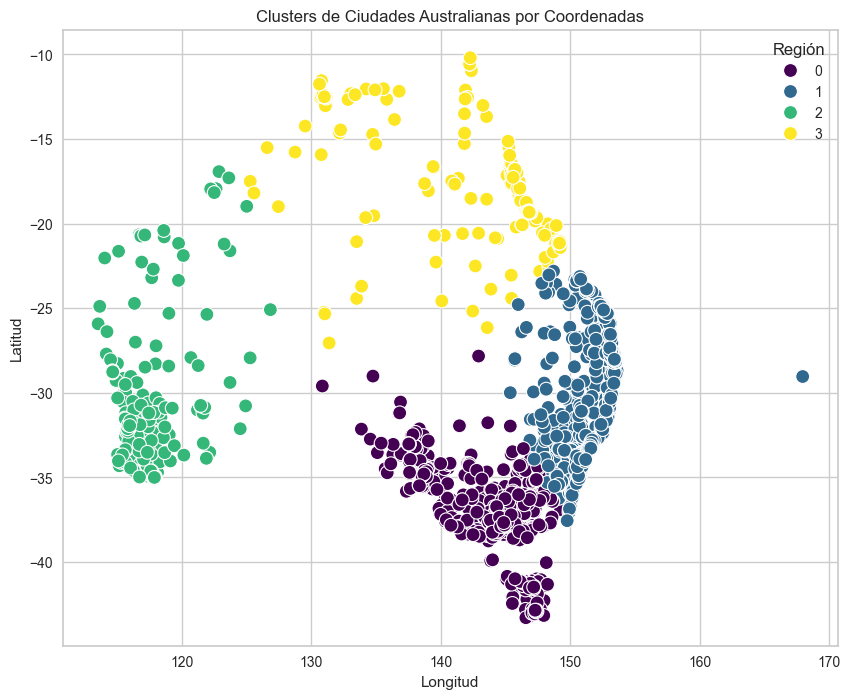

In [9]:
#Seleccionamos las coordenadas para el clustering
coordenadas = ciudades[['latitude', 'longitude']]

# Inicializamos y entrenamos el modelo K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
ciudades['Region'] = kmeans.fit_predict(coordenadas)

#Visualizamos los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='Region',
    data=ciudades,
    palette='viridis',
    s=100)
plt.title('Clusters de Ciudades Australianas por Coordenadas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Región')
plt.grid(True)
plt.show()


Vemos un punto alejado pero es porque es la Isla Norfolk, territorio australiano

In [10]:
# Defimos un diccionario para saber a que region pertenece cada ciuadad
region_perteneciente = {0: 'Sur', 1: 'Este', 2: 'Oeste', 3: 'Norte'}

#Reemplazamos
ciudades['Region'] = ciudades['Region'].replace(region_perteneciente)

In [11]:
ciudades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4135 non-null   float64
 1   id          4135 non-null   float64
 2   name        4156 non-null   object 
 3   latitude    4156 non-null   float64
 4   longitude   4156 non-null   float64
 5   Region      4156 non-null   object 
dtypes: float64(4), object(2)
memory usage: 194.9+ KB


In [12]:
#Antes de hacer el mapeo normalizamos el nombre de las ciudades
clima['Location'] = clima['Location'].str.lower()
clima['Location'] = clima['Location'].str.strip()
clima['Location'] = clima['Location'].str.replace(' ', '')

ciudades['name'] = ciudades['name'].str.lower()
ciudades['name'] = ciudades['name'].str.strip()
ciudades['name'] = ciudades['name'].str.replace(' ', '')


#Creamos un diccionario que guarda como valor la region de cada ciudad
#Dropeamos nombres de ciudades repetidos
mapa_de_regiones = ciudades.drop_duplicates(subset=['name']).set_index('name')['Region']

#repetimos para añadir latitud y longitud
mapa_de_lat = ciudades.drop_duplicates(subset=['name']).set_index('name')['latitude']
mapa_de_lng = ciudades.drop_duplicates(subset=['name']).set_index('name')['longitude']


#Creamos una nueva columna en el DF de clima mapeando la ciudad con el valor del diccionario creado anteriormente
clima['Latitud'] = clima['Location'].map(mapa_de_lat)
clima['Longitud'] = clima['Location'].map(mapa_de_lng)
clima['Region'] = clima['Location'].map(mapa_de_regiones)


clima[['Location','Latitud', 'Longitud', 'Region']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Location  145460 non-null  object 
 1   Latitud   145460 non-null  float64
 2   Longitud  145460 non-null  float64
 3   Region    145460 non-null  object 
dtypes: float64(2), object(2)
memory usage: 4.4+ MB


Vemos que todas las ciudades del df tienen asignada su region correspondiente, por lo tanto la clusterizacion por región esta terminada.

Vamos a verla en un mapa.

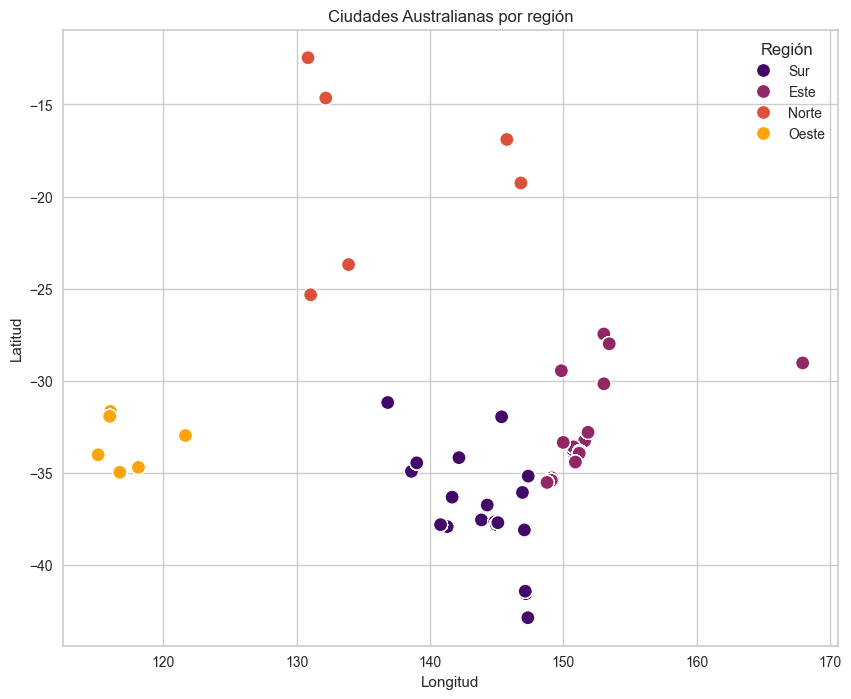

In [13]:
#Visualizamos los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Longitud',
    y='Latitud',
    hue='Region',
    data=clima,
    palette='inferno',
    s=100)
plt.title('Ciudades Australianas por región')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Región')
plt.grid(True)
plt.show()

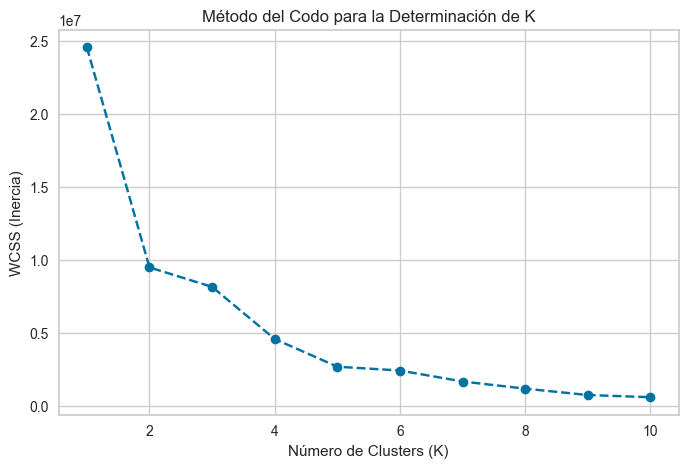

In [14]:
# Extraemos las coordenadas
coordenadas = clima[['Latitud', 'Longitud']].values

# Rango de K a probar
K_range = range(1, 11)
wcss = []

# Calculamos WCSS para cada K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coordenadas)
    wcss.append(kmeans.inertia_)

# Graficamos
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Método del Codo para la Determinación de K')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Inercia)')
plt.grid(True)
plt.show()



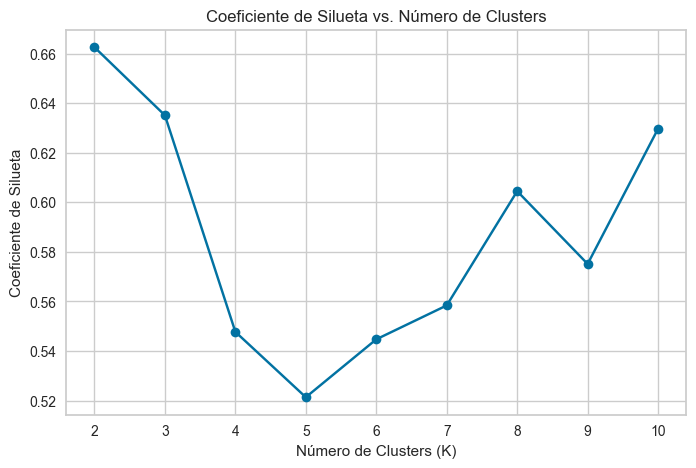

In [15]:
# Determinamos el tamaño de la muestra
n_muestras = int(len(clima) * 0.10)

coordenadas_muestra = clima[['Latitud', 'Longitud']].sample(
    n=n_muestras, random_state=42).values

# Rango de K a probar
K_range_silueta = range(2, 11)
silhouette_scores = []

# Calculamos el Coeficiente de Silueta para cada K
for k in K_range_silueta:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coordenadas_muestra)
    score = silhouette_score(coordenadas_muestra, kmeans.labels_)
    silhouette_scores.append(score)

# Graficamos
plt.figure(figsize=(8, 5))
plt.plot(K_range_silueta, silhouette_scores, marker='o', linestyle='-')
plt.title('Coeficiente de Silueta vs. Número de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Coeficiente de Silueta')
plt.grid(True)
plt.show()

# **Análisis exploratorio y limpieza primaria**


Vemos un paneo general de datos que ya teniamos

In [16]:
print(clima.info())
print(clima.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Vemos que hay filas sin la variable target, no podemos considerarlas útiles si ni si quiera se sabe si llovió o no. Las eliminamos.

In [17]:
clima = clima.dropna(subset=['RainTomorrow'])

clima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

Se borraron un total de 3267 filas.

In [18]:
clima.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitud,Longitud,Region
0,2008-12-01,albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,No,-36.07482,146.92401,Sur
1,2008-12-02,albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,No,-36.07482,146.92401,Sur
2,2008-12-03,albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,No,-36.07482,146.92401,Sur
3,2008-12-04,albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,No,-36.07482,146.92401,Sur
4,2008-12-05,albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,No,-36.07482,146.92401,Sur


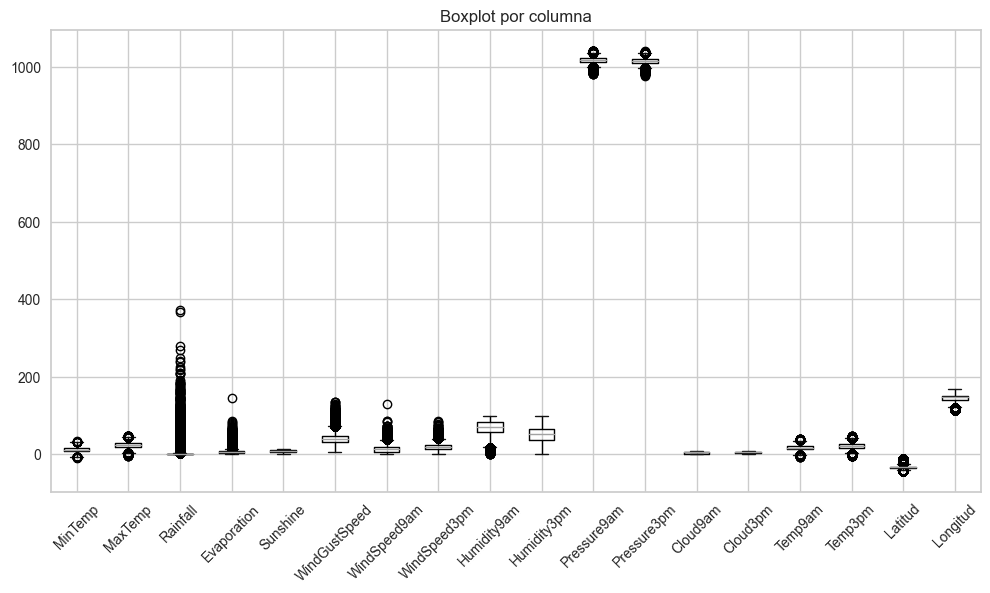

In [19]:
clima.boxplot(figsize=(12,6))
plt.title("Boxplot por columna")
plt.xticks(rotation=45)
plt.show()

Como observamos, no se pueden sacar muchas conclusiones además de que en los datos hay muchos outliers. Hasta que no escalemos las variables no tendremos mucha más información

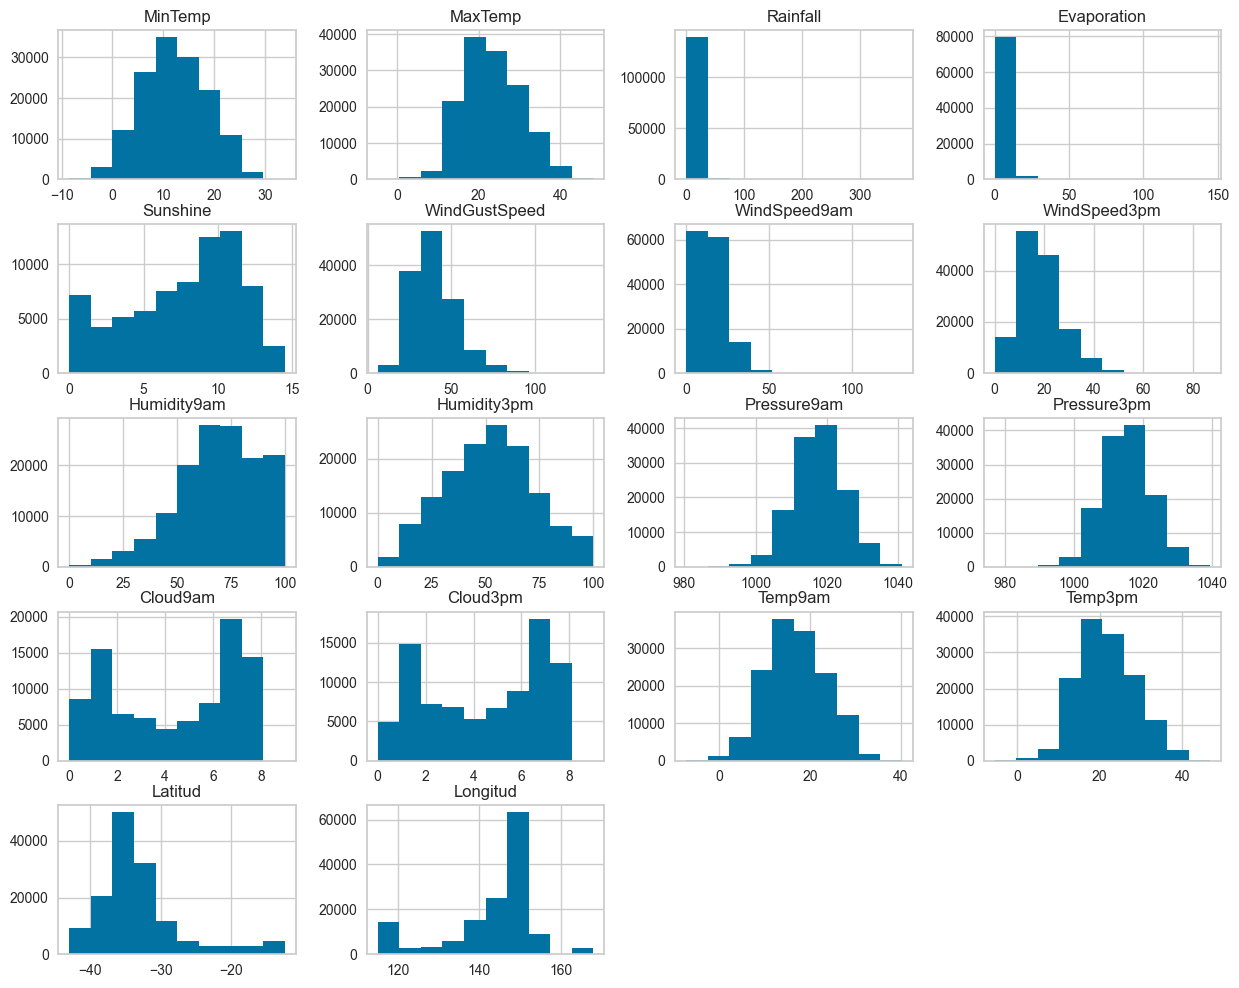

In [20]:
clima.hist(figsize=(15,12))
plt.title("histograma por columna")

plt.show()

In [21]:
#Calculamos el porcentaje de nulos por variable
porcentaje_nulos = clima.isnull().mean() * 100
porcentaje_nulos = porcentaje_nulos.sort_values(ascending=False)
print(porcentaje_nulos)

Sunshine         47.692924
Evaporation      42.789026
Cloud3pm         40.152469
Cloud9am         37.735332
Pressure9am       9.855619
Pressure3pm       9.832411
WindDir9am        7.041838
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir3pm        2.656952
Humidity3pm       2.538803
Temp3pm           1.917113
WindSpeed3pm      1.849599
Humidity9am       1.247600
RainToday         0.988797
Rainfall          0.988797
WindSpeed9am      0.948007
Temp9am           0.635756
MinTemp           0.447983
MaxTemp           0.226453
Longitud          0.000000
Latitud           0.000000
Date              0.000000
RainTomorrow      0.000000
Location          0.000000
Region            0.000000
dtype: float64


Vemos que hay muchos nulos en algunas columnas, casi la mitad de los datos en los que más faltan, por lo que al momento de la imputación (luego de la separación) deberemos seguir un criterio.

In [22]:
#Veamos si el modelo está balanceado
print(clima['RainTomorrow'].value_counts(normalize=True))

RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64


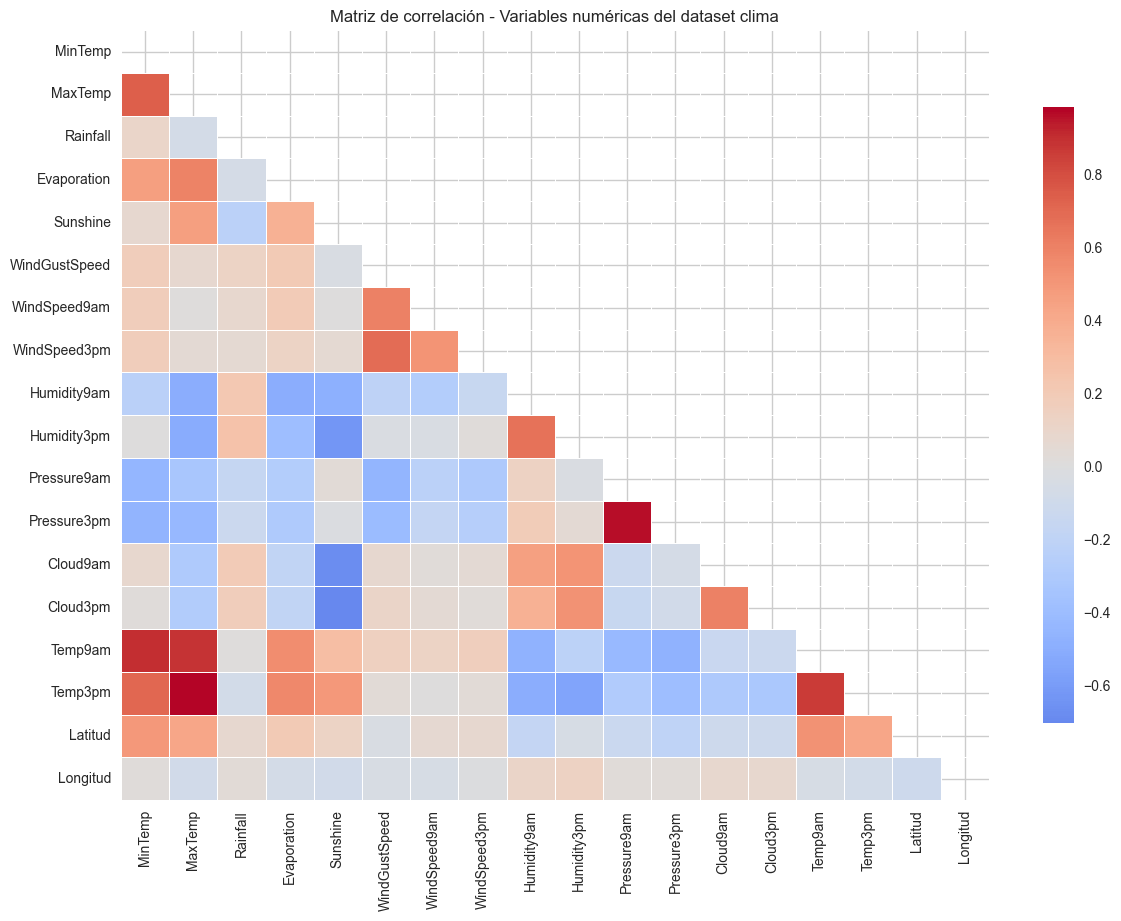

In [23]:
# Filtramos solo columnas numéricas
num_cols = clima.select_dtypes(include='number').columns
df_num = clima[num_cols].copy()

# Calculamos correlación de Pearson
corr = df_num.corr(method='pearson')

# Gráfico triangular de correlaciones
plt.figure(figsize=(14,10))
mask = np.triu(np.ones_like(corr, dtype=bool))  # triángulo superior
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=False, fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8})
plt.title("Matriz de correlación - Variables numéricas del dataset clima")
plt.show()


El dataset está visiblemente desbalanceado.
Esto es importante, y la consigna lo menciona porque, por ejemplo, si tenemos un modelo que solo devuelve "No", tendriamos un accuracy del 77% (que es bastante bueno) cuando en realidad el modelo seria MUY malo.

Haremos el correcto balanceo una vez tengamos dividido y completamente limpio el DF

# **Separación del DF, Limpieza profunda y Modelos de predicción**

### Separación y limpieza

In [24]:
# Separamos las características (X) y el objetivo (y)
x = clima.drop('RainTomorrow', axis=1)
y = clima['RainTomorrow']

# Dividimos en entrenamiento y prueba el DF
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y) #'stratify=y' asegura que la proporción


In [ ]:
#La nubosidad esta medida en octavos (u octas). El valor máximo que pueden tener estas es 8 y hay algunas con valor 9, 
# asi que las que tengan valor 9 las tomamos como el valor máximo (8)

#Calculamos el porcentaje de valores de las columnas "cloud" mayores a 8
porcentaje_cloud_x_train = (x_train[['Cloud9am', 'Cloud3pm']] > 8).mean() * 100
porcentaje_cloud_x_test = (x_test[['Cloud9am', 'Cloud3pm']] > 8).mean() * 100

print(porcentaje_cloud_x_train)
print(porcentaje_cloud_x_test)


x_train.loc[clima['Cloud9am'] == 9, 'Cloud9am'] = 8
x_train.loc[clima['Cloud3pm'] == 9, 'Cloud3pm'] = 8

x_test.loc[clima['Cloud9am'] == 9, 'Cloud9am'] = 8
x_test.loc[clima['Cloud3pm'] == 9, 'Cloud3pm'] = 8


Cloud9am    0.001758
Cloud3pm    0.000879
dtype: float64
Cloud9am    0.0
Cloud3pm    0.0
dtype: float64


In [26]:
# Para evitar problemas en el One-hot, vamos a depurar la fecha

# Converimos la columna 'Date' a formato datetime
x_train['Date'] = pd.to_datetime(x_train['Date'])
x_test['Date'] = pd.to_datetime(x_test['Date'])

# Extraemos mes y numero del día del año
x_train['Month'] = x_train['Date'].dt.month
x_train['DayOfYear'] = x_train['Date'].dt.dayofyear

x_test['Month'] = x_test['Date'].dt.month
x_test['DayOfYear'] = x_test['Date'].dt.dayofyear

# Eliminamos la columna date
x_train = x_train.drop('Date', axis=1)
x_test = x_test.drop('Date', axis=1)


In [27]:
#Calculamos el porcentaje de nulos por variable pero esta vez del x_train
porc_nulos_x_train = x_train.isnull().mean() * 100
porc_nulos_x_train = porc_nulos_x_train.sort_values(ascending=False)
print(porc_nulos_x_train)

Sunshine         47.773265
Evaporation      42.807286
Cloud3pm         40.147160
Cloud9am         37.692740
Pressure9am       9.922288
Pressure3pm       9.900311
WindDir9am        7.081070
WindGustDir       6.579988
WindGustSpeed     6.540429
WindDir3pm        2.695290
Humidity3pm       2.546724
Temp3pm           1.936635
WindSpeed3pm      1.872462
Humidity9am       1.246550
Rainfall          0.994251
RainToday         0.994251
WindSpeed9am      0.951175
Temp9am           0.646131
MinTemp           0.450973
MaxTemp           0.226805
Region            0.000000
Month             0.000000
Location          0.000000
Longitud          0.000000
Latitud           0.000000
DayOfYear         0.000000
dtype: float64


Hay 4 columnas con un porcentaje muy alto de faltantes, asi que tomamos la decisión de hacer pruebas imputando los datos faltantes.

In [28]:
#Latitud y longitud ya no nos sirven más
x_train = x_train.drop(['Latitud', 'Longitud'], axis=1)


In [29]:
cat_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Region']
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                  'Cloud3pm', 'Temp9am', 'Temp3pm', 'Month', 'DayOfYear']

print("Columnas Categóricas:")
print(cat_cols)
print("Columnas Numéricas:")
print(num_cols)

Columnas Categóricas:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Region']
Columnas Numéricas:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Month', 'DayOfYear']


In [30]:
print(x_train[cat_cols].isnull().sum().sort_values(), "\n")
print(x_train[num_cols].isnull().sum().sort_values())

Location          0
Region            0
RainToday      1131
WindDir3pm     3066
WindGustDir    7485
WindDir9am     8055
dtype: int64 

DayOfYear            0
Month                0
MaxTemp            258
MinTemp            513
Temp9am            735
WindSpeed9am      1082
Rainfall          1131
Humidity9am       1418
WindSpeed3pm      2130
Temp3pm           2203
Humidity3pm       2897
WindGustSpeed     7440
Pressure3pm      11262
Pressure9am      11287
Cloud9am         42877
Cloud3pm         45669
Evaporation      48695
Sunshine         54344
dtype: int64


## **Método por imputación**

Primero vamos a entrenar un modelo sin borrar las columnas a ver que tan bien nos dan las métricas para luego compararlas con las del modelo sin las columnas.

#### Codificación y escalado de variables

Primero codificamos las variable target, para que tengamos una serie de 0 y 1 en vez de si y no

In [31]:
# Creamos una instancia del labelEncoder para nuestras variables objetivo
le = LabelEncoder()

# Entrenamos y aplicamos el labelEncoder
y_train_imp = le.fit_transform(y_train)
y_test_imp = le.transform(y_test)


print("Clases aprendidas por el LabelEncoder:", le.classes_)

Clases aprendidas por el LabelEncoder: ['No' 'Yes']


In [32]:
# Pipeline para datos numéricos:
# Paso 1: Imputamos con IterativeImputer las columnas numéricas
# Paso 2: Escalamos los datos
numerical_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler())
])

# Pipeline para datos categóricos:
# Paso 1: Imputamos los faltantes con la moda
# Paso 2: Aplicamos One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Unimos los pipelines en un solo objeto pre-procesador con ColumnTransformer
# Este objeto aplicará las transformaciones necesarias según el tipo de columna que sean
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

# Aplicamos el pre-procesador a los datos
x_train_imp = preprocessor.fit_transform(x_train)
x_test_imp = preprocessor.transform(x_test)


# Verificación
print("Dimensiones de x_train después del pre-procesamiento:", x_train_imp.shape)
print("Dimensiones de x_test después del pre-procesamiento:", x_test_imp.shape)

Dimensiones de x_train después del pre-procesamiento: (113754, 121)
Dimensiones de x_test después del pre-procesamiento: (28439, 121)


Los datos ahora estan en un Numpy array, pasarlos a df es muy caro computacionalmente y nos tiró error de RAM varias veces

#### Entrenamiento y predicción

In [33]:
# Creamos el modelo
regresión_logis = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42) # Usamos class_weight='balanced' para manejar el desbalance de clases.

# Entrenamos el modelo
print("Entrenando el modelo de Regresión Logística...")
regresión_logis.fit(x_train_imp, y_train_imp)
print("Modelo correctamente entrenado")

Entrenando el modelo de Regresión Logística...
Modelo correctamente entrenado


In [34]:
# Realizamos las predicciones
y_pred = regresión_logis.predict(x_test_imp)

In [35]:
#Métricas del modelo
print("Informe de Clasificación:")
print(classification_report(y_test_imp, y_pred))


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.54      0.79      0.64      6375

    accuracy                           0.80     28439
   macro avg       0.73      0.79      0.75     28439
weighted avg       0.84      0.80      0.81     28439



* ***Accuracy***: Vemos que el modelo, en total acierta el 80% de los días, es una buena métrica pero no es la única asi que las comparamos con las demás.
* ***Recall***: De los días que en verdad llovieron, el modelo acerto un 79% de las veces. Podemos decir que el modelo es bastante bueno prediciendo si va a llover.
* ***Precision***: De las veces que el modelo predijo que iba a llover, acertó un 54%. Podriamos decir que es el punto más flojo del modelo haciendote llevar el paragüas por las dudas.
* ***f1-score***: Es un promedio entre el Recall y la Precision, al ser uno alto y e otro bajo el f1-score quedo bastante balanceado con 64%.

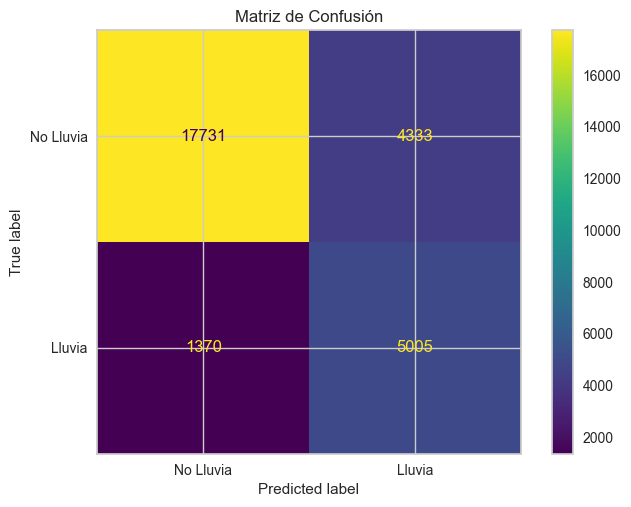

In [36]:
#Matriz de falsos positivos y falsos negativos
cm = confusion_matrix(y_test_imp, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Lluvia', 'Lluvia'])
disp.plot()
plt.title("Matriz de Confusión")
plt.show()

En la matriz de confusión, vemos que el modelo acierta bastante. Tenemos un total de aproximadamente 23000 aciertos contra 5300 errores, de los cuales nos mojariamos en 1278 veces que es lo que queremos evitar, los falsos negativos.

#### Evaluación con curva ROC

AUC: 0.8774


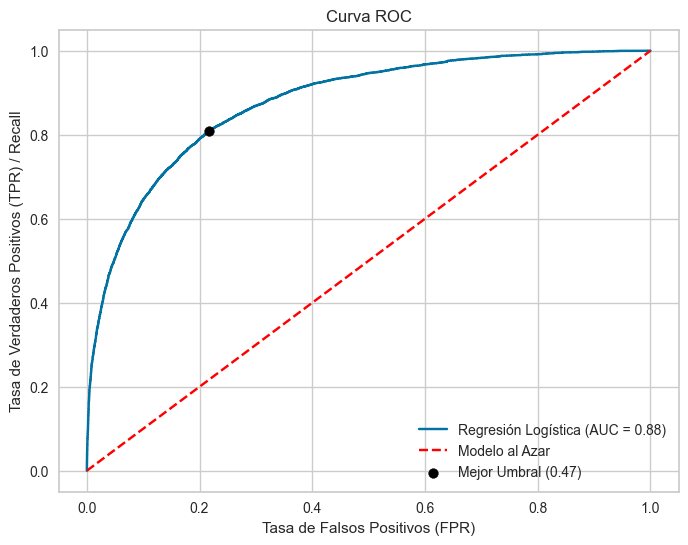

In [37]:
# Obtenemos las probabilidades de predicción (necesarias para la curva ROC)
y_pred_proba = regresión_logis.predict_proba(x_test_imp)[:, 1]

# Calcular el AUC (Área debajo de la curva)
auc = roc_auc_score(y_test_imp, y_pred_proba)
print(f'AUC: {round(auc, 4)}')

# Calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_imp, y_pred_proba) #False postive rate - True postive rate - Umbral

# Calculamos el G-Mean (Media geométrica) para cada umbral
gmeans = np.sqrt(tpr * (1 - fpr))
# Encontramos el índice (la posición) del G-Mean más grande
ix = np.argmax(gmeans)
# Obtenemos el umbral que corresponde a esa posición
best_threshold = thresholds[ix]


# Graficamos
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Regresión Logística (AUC = {round(auc, 2)})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Modelo al Azar')
# Dibujamos un punto en la coordenada (FPR, TPR) que corresponde al mejor umbral
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Mejor Umbral ({round(best_threshold, 2)})', zorder=5) # 'zorder=5' hace que el punto se dibuje por encima de la línea, simple estética
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

En la curva ROC, vemos que el modelo supera ampliamente la línea del modelo aleatorio. También vemos que el umbral óptimo es bastante cercano al 0.5

In [38]:
y_pred_opt = (y_pred_proba >= best_threshold).astype(int)


#Métricas del modelo imputado
print("Metricas modelo imputado:")
print(classification_report(y_test_imp, y_pred))

print("========================================================")

# Métricas del modelo imputado óptimo
print(f"Métricas con el umbral óptimo ({round(best_threshold, 2)}):")
print(classification_report(y_test_imp, y_pred_opt))


Metricas modelo imputado:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.54      0.79      0.64      6375

    accuracy                           0.80     28439
   macro avg       0.73      0.79      0.75     28439
weighted avg       0.84      0.80      0.81     28439

Métricas con el umbral óptimo (0.47):
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     22064
           1       0.52      0.81      0.63      6375

    accuracy                           0.79     28439
   macro avg       0.73      0.80      0.74     28439
weighted avg       0.84      0.79      0.80     28439



El modelo de Regresión Logística ajustado con un umbral de 0.46 (según la G-Mean) alcanza un AUC de 0.88 y una accuracy de 0.80, mostrando buena capacidad para distinguir días con y sin lluvia.

El recall del 80% en la clase “Lluvia” indica que el modelo identifica correctamente la mayoría de los días lluviosos, aunque con una precisión del 53%. Los puntajes F1 similares entre entrenamiento (0.66) y prueba (0.65) sugieren que no hay overfitting.

En síntesis, el modelo ofrece un buen equilibrio entre precisión y recall, priorizando la detección de días lluviosos, que es el objetivo principal del proyecto.

#### Análisis de fitting

In [39]:
#Verificamos el fitting a través del f1-score

# Puntuación con los datos de entrenamiento
score_train = f1_score(y_train_imp, regresión_logis.predict(x_train_imp))

# Puntuación con los datos de testeo (la misma que ya teníamos en la predicción orignal)
score_test = f1_score(y_test_imp, regresión_logis.predict(x_test_imp))


print(f"Puntaje F1 (Train): {round(score_train, 4)}")
print(f"Puntaje F1 (Test):  {round(score_test, 4)}")

Puntaje F1 (Train): 0.6339
Puntaje F1 (Test):  0.6371


Vemos con los puntajes que el modelo es consistente, no hay señales de overfitting o de underfitting.

## **Modelo base**

Como modelo base elegimos hacer un modelo que prediga sin contar con las columnas que poseen mayor numero de faltantes.

In [40]:
columnas_a_eliminar = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
x_train_base = x_train.drop(columns=columnas_a_eliminar)
x_test_base = x_test.drop(columns=columnas_a_eliminar)

In [41]:
# Separamos las columnas en categóricas y numéricas

cat_cols_base = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Region']
num_cols_base = ['MinTemp', 'MaxTemp', 'Rainfall',
                  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Month', 'DayOfYear']

print("Columnas Categóricas:")
print(cat_cols_base)
print("Columnas Numéricas:")
print(num_cols_base)

Columnas Categóricas:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Region']
Columnas Numéricas:
['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Month', 'DayOfYear']


#### Codificación y escalado de variables

In [42]:
# Creamos una instancia del labelEncoder para nuestras variables objetivo
le = LabelEncoder()

# Entrenamos y aplicamos el labelEncoder
y_train_base = le.fit_transform(y_train)
y_test_base = le.transform(y_test)


print("Clases aprendidas por el LabelEncoder:", le.classes_)

Clases aprendidas por el LabelEncoder: ['No' 'Yes']


In [43]:
# Pipeline para datos numéricos (modelo base):

# Paso 1: Imputamos los faltantes con la mediana
# Paso 2: Escalamos los datos
numerical_transformer_base = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para datos categóricos (modelo base):
# Paso 1: Imputamos los faltantes con la moda
# Paso 2: Aplicamos One-Hot Encoding
categorical_transformer_base = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Unimos los pipelines en un solo objeto pre-procesador con ColumnTransformer
preprocessor_base = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_base, num_cols_base),
        ('cat', categorical_transformer_base, cat_cols_base)])

# Aplicamos el pre-procesador a los datos del modelo base
x_train_base_procesados = preprocessor_base.fit_transform(x_train_base)
x_test_base_procesados = preprocessor_base.transform(x_test_base)

# Verificación
print("Forma de x_train_base después del pre-procesamiento:", x_train_base_procesados.shape)
print("Forma de x_test_base después del pre-procesamiento:", x_test_base_procesados.shape)

Forma de x_train_base después del pre-procesamiento: (113754, 117)
Forma de x_test_base después del pre-procesamiento: (28439, 117)


#### Entrenamiento y evaluación del Modelo Base

In [44]:
# Creamos el modelo de Regresión Logística para el modelo base
regresion_logis_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Entrenamos el modelo base
print("Entrenando el modelo de Regresión Logística (Base)...")
regresion_logis_base.fit(x_train_base_procesados, y_train_base)
print("Modelo Base correctamente entrenado")

Entrenando el modelo de Regresión Logística (Base)...
Modelo Base correctamente entrenado


Informe de Clasificación (Modelo Base):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22064
           1       0.52      0.77      0.62      6375

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.74     28439
weighted avg       0.83      0.79      0.80     28439



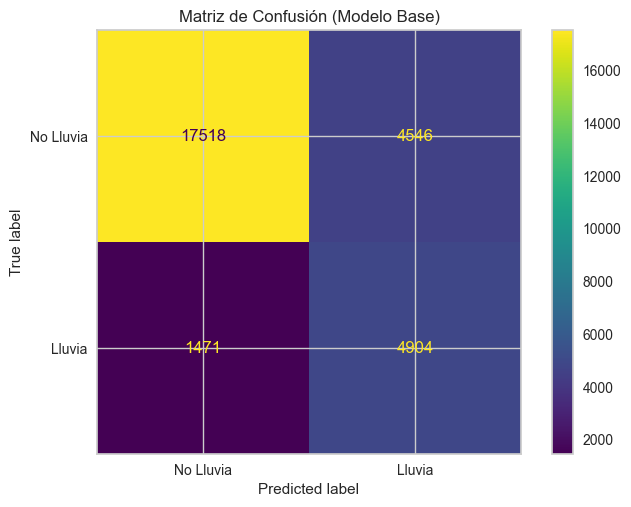

In [45]:
# Realizamos las predicciones con el modelo base
y_pred_base = regresion_logis_base.predict(x_test_base_procesados)

# Métricas del modelo base
print("Informe de Clasificación (Modelo Base):")
print(classification_report(y_test_base, y_pred_base))

# Matriz de Confusión (Modelo Base)
cm_base = confusion_matrix(y_test_base, y_pred_base)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=['No Lluvia', 'Lluvia'])
disp_base.plot()
plt.title("Matriz de Confusión (Modelo Base)")
plt.show()

Comparando los resultados primarios obtenidos en en este modelo base, vemos que las métricas obtenidas son un poco peores que las del modelo por imputación, quedando definido que la decisión de usar el IterativeImputer fue adecuada.

#### Evaluación con curva ROC

AUC: 0.8638


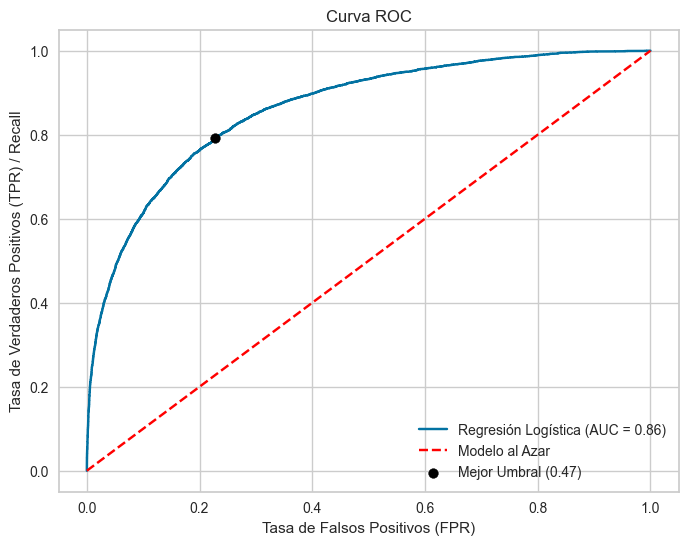

In [46]:
# Obtenemos las probabilidades de predicción (necesarias para la curva ROC)
y_pred_proba_base = regresion_logis_base.predict_proba(x_test_base_procesados)[:, 1]

# Calcular el AUC (Área debajo de la curva)
auc_base = roc_auc_score(y_test_base, y_pred_proba_base)
print(f'AUC: {round(auc_base, 4)}')

# Calculamos la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_base, y_pred_proba_base) #False postive rate - True postive rate - Umbral

# Calculamos el G-Mean (Media geométrica) para cada umbral
gmeans = np.sqrt(tpr * (1 - fpr))
# Encontramos el índice (la posición) del G-Mean más grande
ix = np.argmax(gmeans)
# Obtenemos el umbral que corresponde a esa posición
best_threshold_base = thresholds[ix]


# Graficamos
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Regresión Logística (AUC = {round(auc_base, 2)})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Modelo al Azar')
# Dibujamos un punto en la coordenada (FPR, TPR) que corresponde al mejor umbral
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Mejor Umbral ({round(best_threshold_base, 2)})', zorder=5) # 'zorder=5' hace que el punto se dibuje por encima de la línea, simple estética
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred_opt_base = (y_pred_proba_base >= best_threshold_base).astype(int)


# Métricas del modelo base
print("Informe de Clasificación (Modelo Base):")
print(classification_report(y_test_base, y_pred_base))

print("========================================================")

# Métricas del modelo base óptimo
print(f"Métricas con el umbral óptimo ({round(best_threshold_base, 2)}):")
print(classification_report(y_test_base, y_pred_opt_base))


Informe de Clasificación (Modelo Base):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22064
           1       0.52      0.77      0.62      6375

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.74     28439
weighted avg       0.83      0.79      0.80     28439

Métricas con el umbral óptimo (0.47):
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     22064
           1       0.50      0.79      0.61      6375

    accuracy                           0.78     28439
   macro avg       0.71      0.78      0.73     28439
weighted avg       0.83      0.78      0.79     28439



Como vemos, el umbral óptimo no mejora significativamente la calidad del modelo. Habiamos notado que el umbral óptimo estaba muy cerca del 0.5

#### Análisis del fitting

In [48]:
#Verificamos el fitting a través del f1-score

# Puntuación con los datos de entrenamiento
score_train = f1_score(y_train_base, regresion_logis_base.predict(x_train_base_procesados))

# Puntuación con los datos de testeo (la misma que ya teníamos en la predicción orignal)
score_test = f1_score(y_test_base, regresion_logis_base.predict(x_test_base_procesados))


print(f"Puntaje F1 (Train): {round(score_train, 4)}")
print(f"Puntaje F1 (Test):  {round(score_test, 4)}")

Puntaje F1 (Train): 0.6183
Puntaje F1 (Test):  0.6198


No se aprecia overfitting en la comparación

## Comparación modelos

In [49]:
#Métricas del modelo imputado
print("Informe de Clasificación (Modelo por imputación):")
print(classification_report(y_test_imp, y_pred))

print("========================================================")

# Métricas del modelo base
print("Informe de Clasificación (Modelo Base):")
print(classification_report(y_test_base, y_pred_base))

Informe de Clasificación (Modelo por imputación):
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.54      0.79      0.64      6375

    accuracy                           0.80     28439
   macro avg       0.73      0.79      0.75     28439
weighted avg       0.84      0.80      0.81     28439

Informe de Clasificación (Modelo Base):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22064
           1       0.52      0.77      0.62      6375

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.74     28439
weighted avg       0.83      0.79      0.80     28439



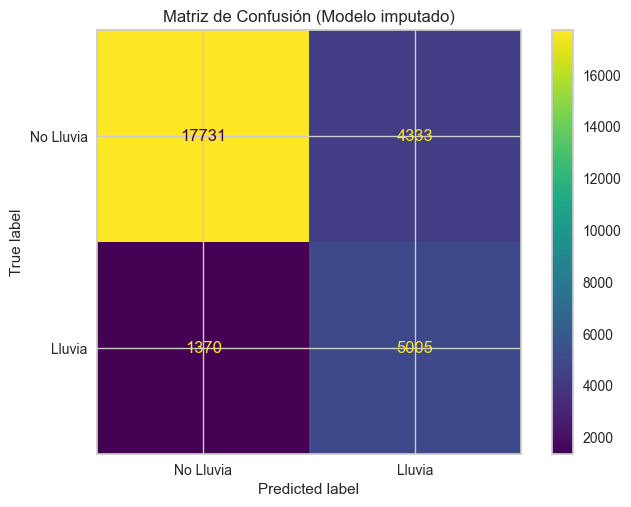

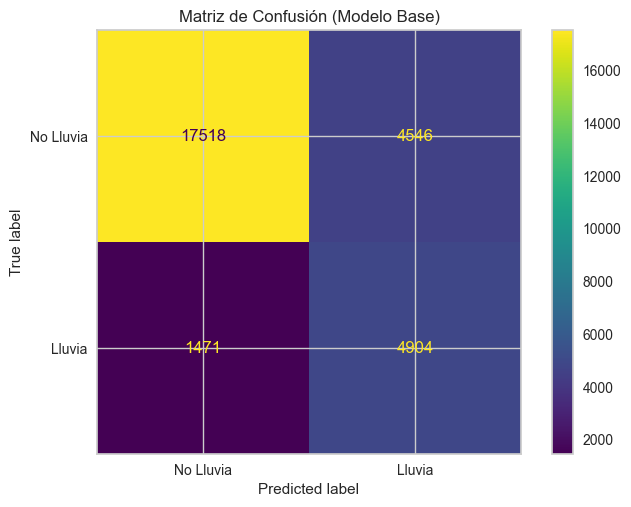

In [50]:
# Matriz de Confusión (Modelo imputado)
cm = confusion_matrix(y_test_imp, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Lluvia', 'Lluvia'])
disp.plot()
plt.title("Matriz de Confusión (Modelo imputado)")
plt.show()

# Matriz de Confusión (Modelo Base)
cm_base = confusion_matrix(y_test_base, y_pred_base)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=['No Lluvia', 'Lluvia'])
disp_base.plot()
plt.title("Matriz de Confusión (Modelo Base)")
plt.show()

In [51]:
# Métricas del modelo imputado óptimo
print(f"Métricas con el umbral óptimo ({round(best_threshold, 2)}) modelo imputado:")
print(classification_report(y_test_imp, y_pred_opt))

print("========================================================")

# Métricas del modelo base óptimo
print(f"Métricas con el umbral óptimo ({round(best_threshold_base, 2)}) modelo base:")
print(classification_report(y_test_base, y_pred_opt_base))



Métricas con el umbral óptimo (0.47) modelo imputado:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     22064
           1       0.52      0.81      0.63      6375

    accuracy                           0.79     28439
   macro avg       0.73      0.80      0.74     28439
weighted avg       0.84      0.79      0.80     28439

Métricas con el umbral óptimo (0.47) modelo base:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     22064
           1       0.50      0.79      0.61      6375

    accuracy                           0.78     28439
   macro avg       0.71      0.78      0.73     28439
weighted avg       0.83      0.78      0.79     28439



Análisis sobre los modelos no óptimos:


El modelo con imputación logra ligeras mejoras de desempeño frente al base, especialmente en la clase minoritaria, lo que sugiere que la estrategia de imputar valores faltantes ayudó a conservar información útil.

No hay indicios de overfitting, ya que la performance es estable entre entrenamiento y test.

Clase 0 (mayoritaria - No llueve):
Presenta una alta precisión (0.93) y un recall moderado (0.82).
Esto significa que el modelo es muy confiable al predecir esta clase (pocos falsos positivos), aunque deja escapar algunos casos que deberían ser clase 0.

Clase 1 (minoritaria - Si llueve):
Mejora respecto al modelo base, con un F1 de 0.66 frente a 0.64.
El recall alto (0.80) indica que el modelo detecta bien la clase positiva, aunque la precisión (0.56) revela que aún hay falsos positivos.

# **Ajuste de hiperparámetros**

Para el TP, decidimos elegir un modelo de ***RandomSearch***.

* Descarte de **GridSearch**: Grid Search presenta un costo computacional muy alto para nuestro pipeline. Dado que nuestro pre-procesamiento tiene pasos ya  costosos como IterativeImputer, la evaluación de todas las combinaciones de la grilla multiplicada por los k-folds de la validación cruzada conllevaría un tiempo de ejecución y un consumo de RAM excesivos, superando los recursos disponibles.

* Descarte de **Optuna**: Si bien Optuna es potente y eficiente, su implementación nos pareció exesiva para el Tp, considerando una sintaxis diferente y un poder que (en este caso) podría ser igualado con un RandomSearch.

* Eleccion de **RandomSearch**: Se optó por Random Search al ser la solución que ofrece el mejor equilibrio entre eficiencia y rendimiento. Esta eficiencia es crucial para nuestro pipeline "pesado", permitiéndonos encontrar un modelo de alto rendimiento de manera efectiva y con un costo y tiempo razonable.

In [52]:
# Usamos los datos ya pre-procesados
x_train_procesado = x_train_imp
x_test_procesado = x_test_imp

# Elegimos el tipo de modelo que vamos a usar y definimos los parámetros que NO queremos optimizar
log_reg_model = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

# Pasamos un diccionario con los parámetros que si debe variar y las opciones
param_dist = {
    'C': loguniform(0.001, 100),     #Balance entre un modelo muy simple y uno muy complejo
    'penalty': ['l1', 'l2'],         #Que tipo de "castigo" funciona mejor (lasso o ridge)
    'solver': ['liblinear', 'saga']  #algoritmo específico que usa el modelo para encontrar la mejor solución (los mejores pesos)
}

# Configuramos con random_search
print("\nIniciando optimización de hiperparámetros")

random_search = RandomizedSearchCV(
    log_reg_model,                     #Pasamos el modelo
    param_distributions=param_dist,    #Pasamos los paráetros que debe ajustar
    n_iter=10,                         #Cantidad de combinaciones que prueba
    cv=5,                              #Validacion cruzada para cada una de las combinaciones que prueba
    scoring='roc_auc',                 #La métrica que debe usar para decidir la "mejor" combinación
    random_state=42,
    n_jobs=-1,                         #Cantidad de nucleos del pc que usa
    verbose=2                          #El modelo "Explica" lo que esta ejecutando
)

# Ejecutamos la búsqueda sobre los datos
random_search.fit(x_train_procesado, y_train_imp)

print("Optimización completada")

# Revisamos los resultados
print(f"Mejor puntaje (AUC) de validación cruzada: {round(random_search.best_score_, 4)}")

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Guardamos el mejor modelo
best_model_optimized = random_search.best_estimator_


Iniciando optimización de hiperparámetros (modo ligero)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
¡Optimización completada!

Mejor puntaje (AUC) de validación cruzada: 0.8746

Mejores hiperparámetros encontrados:
{'C': 0.14445251022763064, 'penalty': 'l1', 'solver': 'liblinear'}


Ahora podemos usar este 'best_model_optimized' para predecir

In [53]:
# Generar las predicciones de clase (0 o 1)
y_pred_ajustado = best_model_optimized.predict(x_test_procesado)

# Generar las probabilidades de predicción (para el nuevo AUC)
y_proba_ajustado = best_model_optimized.predict_proba(x_test_procesado)[:, 1]

In [54]:
#Métricas del modelo imputado
print("Metricas modelo imputado:")
print(classification_report(y_test_imp, y_pred))

print("-------------------------------------------------")

# Imprimimos el informe de clasificación
print("\nInforme de Clasificación (Modelo Optimizado):\n")
print(classification_report(y_test_imp, y_pred_ajustado))

Metricas modelo imputado:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.54      0.79      0.64      6375

    accuracy                           0.80     28439
   macro avg       0.73      0.79      0.75     28439
weighted avg       0.84      0.80      0.81     28439

-------------------------------------------------

Informe de Clasificación (Modelo Optimizado):

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     22064
           1       0.54      0.78      0.64      6375

    accuracy                           0.80     28439
   macro avg       0.73      0.79      0.75     28439
weighted avg       0.84      0.80      0.81     28439




Matriz de Confusión (Modelo Optimizado):



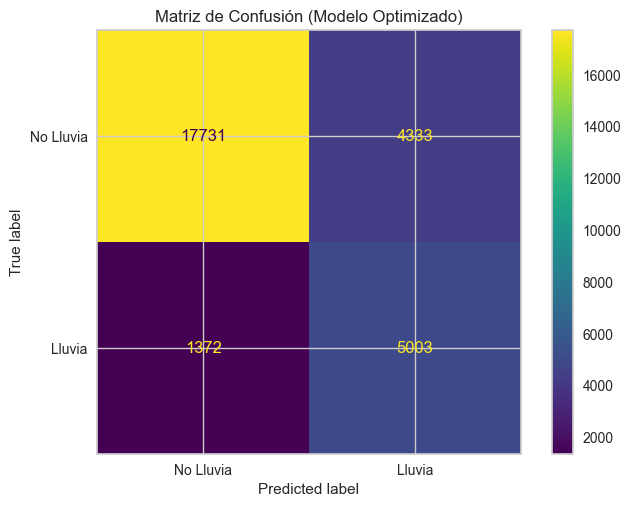

In [55]:
print("\nMatriz de Confusión (Modelo Optimizado):\n")
# Graficamos la nueva matriz
cm_optimized = ConfusionMatrixDisplay.from_estimator(
    best_model_optimized,
    x_test_procesado,
    y_test_imp,
    display_labels=['No Lluvia', 'Lluvia']
)

plt.title("Matriz de Confusión (Modelo Optimizado)")
plt.show()

Se implementó un RandomizedSearchCV para optimizar el modelo, pero los resultados no mejoraron al modelo original; de hecho, el recall empeoró marginalmente (0.79 vs 0.78).

Esto puede deberse a dos motivos principales:

Métricas Desconectadas: Optimizamos buscando el mejor roc_auc, pero esta métrica no garantiza un mejor f1-score o recall en el umbral de decisión por defecto (0.5).

Modelo Base ya Óptimo: Es muy probable que nuestro modelo original, con class_weight='balanced', ya estuviera en el "techo" de rendimiento posible para una Regresión Logística.


# **Explicabilidad de los modelos**

Utilizaremos la biblioteca SHAP para analizar e interpretar por qué el modelo 'toma' ciertas decisiones:

In [56]:

explainer = shap.LinearExplainer(
    model=regresión_logis,                 #Le pasamos el modelo "óptimo"
    masker=x_train_imp,
    feature_perturbation="interventional"
)

# Calculamos los valores SHAP
shap_values = explainer.shap_values(x_test_imp)

In [57]:
#Obtenemos los nombres de las features:
# Nombres de las features categóricas
cat_features_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)

# Nombres de las features numéricas
num_features_names = num_cols

# Juntamos todas las listas de nombres EN EL ORDEN CORRECTO
all_feature_names = list(num_features_names) + list(cat_features_names)

#Definimos la variable explanation que nos sirve para graficar
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=all_feature_names, data=x_test_imp)

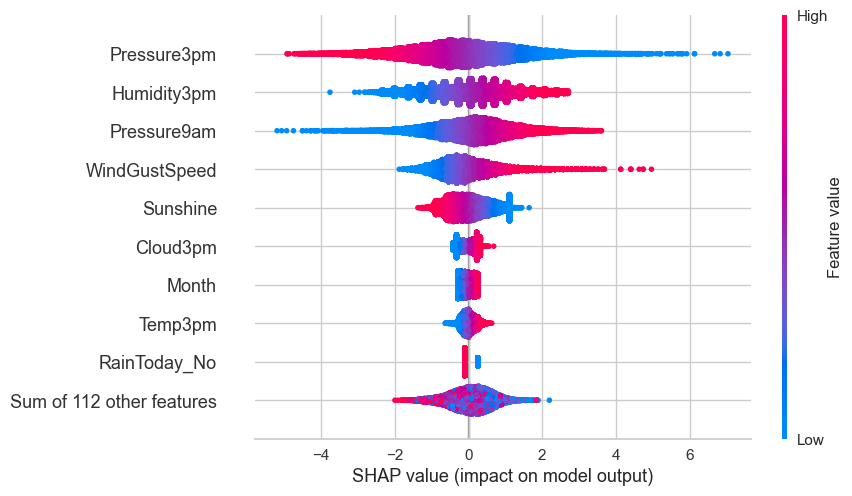

In [58]:
#Gáfico de puntos
shap.plots.beeswarm(explanation)

Para entender el grafico debemos saber que si los valores superan el 0 en el eje X (SHAP value), significa que esa variable aumenta las probabilidades de lluvia, mientras que al bajar el valor de SHAP, dichas probabilidades disminuyen. Por otro lado, el color del punto nos indica si es un valor alto o bajo.
Por ejemplo, en el caso de la **Presión a las 3pm** vemos que una presión baja (azul) aumenta las posibilidades de lluvia (tiende hacia la derecha del gráfico), mientras que una presión alta (rojo) las disminuye (izquierda).

Generando gráfico de fuerza (instancia 0):


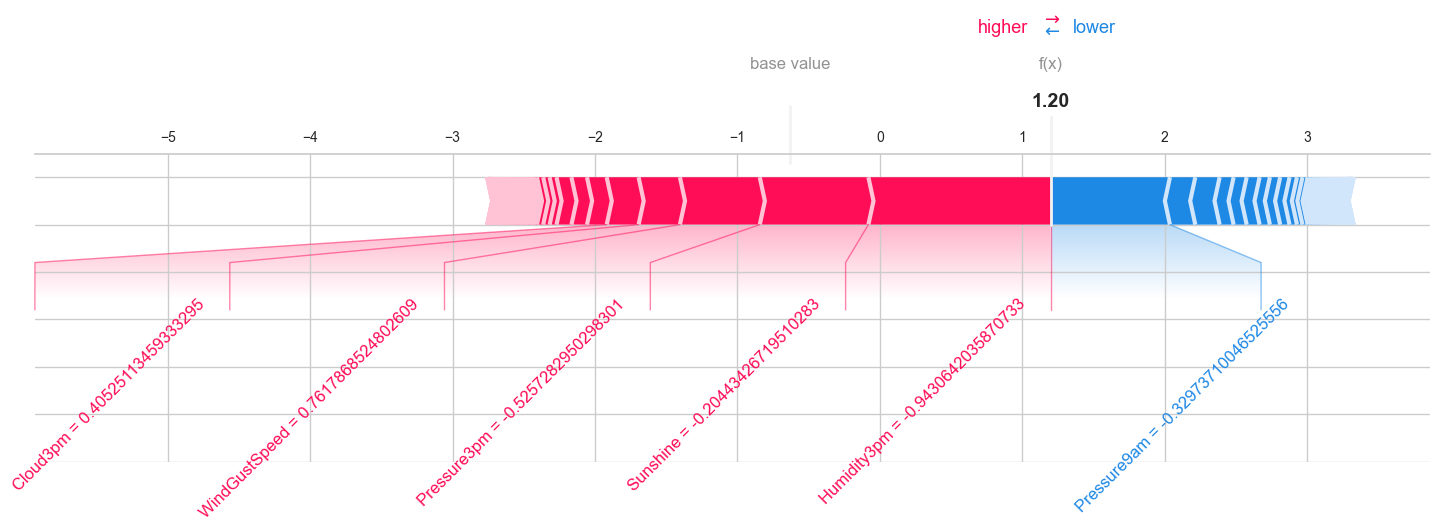

In [59]:
#Gráfico de fuerza

# Seleccionamos la primera fila de los datos PROCESADOS
instancia_a_explicar = x_test_imp[0]
instancia_densa = instancia_a_explicar.toarray().flatten()

# Graficamos
print("Generando gráfico de fuerza (instancia 0):")
shap.force_plot(
    explainer.expected_value,
    shap_values[1],                     # SHAP values de la instancia 1
    instancia_densa,
    feature_names=all_feature_names,
    matplotlib=True,
    figsize=(18, 4),
    text_rotation=45
)
plt.show()

* Valor Base: Este es el "punto de partida" del modelo. Si el modelo no supiera nada de este día, predeciría -0.63 (un valor que por defecto tiende a "No llueve").

* Flechas Rojas: Son las características de este día que 'empujan' la predicción hacia arriba (más probable que llueva). Cuanto más grande es la flecha, más afecta la variable.

* Flechas Azules : Son las características que 'empujan' la predicción hacia abajo (menos probable que llueva).

En este caso, el valor final es de 1.20, indicandonos altas probabilidades de lluvia, propiciado según las variables "Cloud3pm", "pressure3pm" entre otras.


Bar Plot (Con Nombres):


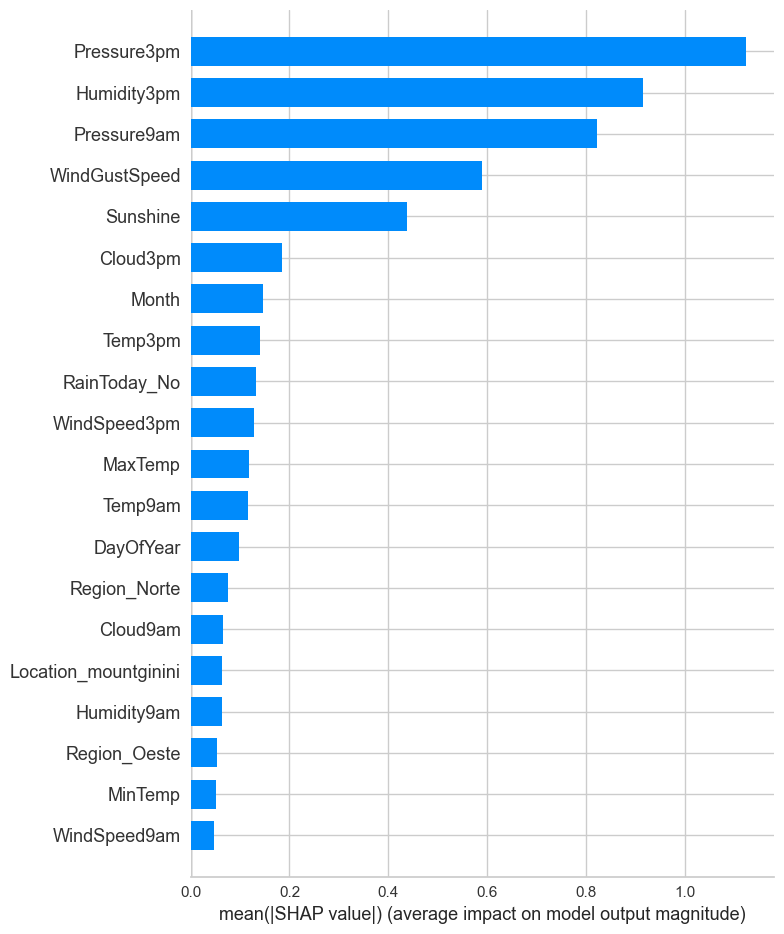

In [60]:
print("\nBar Plot (Con Nombres):")
shap.summary_plot(shap_values, x_test_imp, plot_type="bar", feature_names=all_feature_names)
plt.show()

Los gráficos muestran que las condiciones atmosféricas de la tarde son, por lejos, las más importantes para predecir si lloverá mañana.
En resumen, el modelo 'aprendió' la lógica meteorológica básica: días húmedos, ventosos, nublados y con baja presión tienden a ser seguidos por un día de lluvia.

# **AutoML**

A continuación vamos implementar un modelo de Auto Machine Learning con la biblioteca PyCaret

In [61]:
# Convertimos y_train para que tenga el mismo índice que x_train
y_train_series = pd.Series(y_train, index=x_train.index, name='RainTomorrow')

# Ahora concatenamos sin romper las filas
train_df = pd.concat([x_train, y_train_series], axis=1)
test_df = x_test


En el siguiente bloque de código, se configura el entorno de PyCaret y testean diversos modelos, para determinar cuál es el de mejores métricas y optimizarlo.
Luego de probar todos los modelos disponibles, para reducir el tiempo de ejecución, se utilizó solo el top 6 de los que mejor resultaron. Además, se eliminó el remove_multicollinearity=True porque no traía ventajas, y se redujo el k para la validación cruzada de 10 a 5 

In [62]:
# Configurar el entorno de PyCaret (describimos cómo es el dataset para que automáticamente pycaret se encargue de todo el pre-procesamiento)

print("Configurando el entorno de PyCaret...")
s = setup(
    data=train_df,                 # DF de entrenamiento (el primero, sin escalado ni codificación)
    target='RainTomorrow',         # columna objetivo
    session_id=42,                 # para que los resultados sean reproducibles
    fix_imbalance=False,           # Aplica smote para solucionar el desbalance
   #remove_multicollinearity=True, # Elimina variables muy correlacionadas para mejorar el modelo, finalmente no afectó en nada a los resultados
    normalize=True                 # Escala los datos (como StandardScaler)
)


print("\n¡Configuración completada!")

# Comparar todos los modelos:

print("\nComparando los 6 mejores modelos...")

top_models = ['lightgbm', 'gbc', 'rf', 'et', 'lr', 'ada']   # los que mejor resultaron al ejecutar todos lo modelos

best_model = compare_models(sort='AUC', fold=5, include=top_models) # ordenamos por AUC, podría ser por otro - fold por defecto es 10, lo que ralentiza la ejecución

print("\n¡Comparación completada!")
print("\nEl mejor modelo encontrado es:")
print(best_model)


Configurando el entorno de PyCaret...


,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(113754, 25)"
5,Transformed data shape,"(113754, 73)"
6,Transformed train set shape,"(79627, 73)"
7,Transformed test set shape,"(34127, 73)"
8,Numeric features,18
9,Categorical features,6



¡Configuración completada!

Comparando los 6 mejores modelos...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8587,0.8896,0.8587,0.8511,0.8502,0.5498,0.5608,2.5180
rf,Random Forest Classifier,0.8554,0.8851,0.8554,0.8479,0.8435,0.5249,0.5435,6.3840
et,Extra Trees Classifier,0.8533,0.8836,0.8533,0.8458,0.8402,0.5137,0.5348,6.2640
gbc,Gradient Boosting Classifier,0.8507,0.8753,0.8507,0.8418,0.8397,0.5152,0.5300,9.0020
lr,Logistic Regression,0.8433,0.8670,0.8433,0.8331,0.8327,0.4954,0.5077,0.7700
ada,Ada Boost Classifier,0.8428,0.8632,0.8428,0.8324,0.8319,0.4927,0.5053,3.1140



¡Comparación completada!

El mejor modelo encontrado es:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


LGBMClassifier resultó ser el mejor modelo, ahora lo creamos y optimizamos sus hiperparámetros.
Utilizamos fold=5 y n_iter=5 ya que reducen a menos de la mitad el tiempo de ejecución y la diferencia en métricas es marginal


In [63]:
lgbm = create_model('lightgbm')

tuned_lgbm = tune_model(lgbm, optimize='AUC', fold=5, n_iter=5)

# Finalizamos el modelo, acá se re-entrena con todos los datos.
final_model = finalize_model(tuned_lgbm)

# Ahora, usamos el modelo final parap predecir sobre los datos de prueba
predictions = predict_model(final_model, data=test_df, raw_score=True)

# Mostramos el resultado, PyCaret añade las columnas 'prediction_label' y 'prediction_score'
print("\nVista de las predicciones:")
predictions.head()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8570,0.8855,0.8570,0.8491,0.8478,0.5422,0.5541
1,0.8555,0.8925,0.8555,0.8473,0.8468,0.5398,0.5503
2,0.8556,0.8860,0.8556,0.8475,0.8468,0.5399,0.5506
3,0.8582,0.8866,0.8582,0.8505,0.8498,0.5490,0.5595
4,0.8645,0.8979,0.8645,0.8578,0.8562,0.5676,0.5792
5,0.8590,0.8927,0.8590,0.8514,0.8510,0.5534,0.5630
6,0.8568,0.8847,0.8568,0.8489,0.8475,0.5409,0.5531
7,0.8623,0.8945,0.8623,0.8553,0.8541,0.5617,0.5727
8,0.8602,0.8937,0.8602,0.8528,0.8514,0.5528,0.5647


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8599,0.8921,0.8599,0.8526,0.8530,0.5609,0.5686
1,0.8576,0.8889,0.8576,0.8498,0.8497,0.5498,0.5590
2,0.8605,0.8964,0.8605,0.8532,0.8534,0.5622,0.5701
3,0.8603,0.8913,0.8603,0.8530,0.8525,0.5580,0.5676
4,0.8617,0.8959,0.8617,0.8546,0.8541,0.5630,0.5723
Mean,0.8600,0.8929,0.8600,0.8526,0.8525,0.5588,0.5675
Std,0.0014,0.0028,0.0014,0.0015,0.0015,0.0048,0.0046


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3

Vista de las predicciones:


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp3pm,RainToday,Latitud,Longitud,Region,Month,DayOfYear,prediction_label,prediction_score_No,prediction_score_Yes
48872,canberra,15.1,32.900002,0.0,NaN,NaN,E,50.0,E,W,...,30.299999,No,-35.283459,149.128067,Este,1,26,No,0.7888,0.2112
100864,mountgambier,8.4,16.200001,0.0,4.0,2.3,WSW,46.0,N,W,...,14.600000,No,-37.824692,140.781906,Sur,9,256,Yes,0.4720,0.5280
123233,perth,17.0,24.700001,0.0,6.0,8.3,SW,39.0,S,SSW,...,24.200001,No,-41.572311,147.170959,Sur,11,310,No,0.6228,0.3772
7228,cobar,12.3,18.799999,0.0,4.2,NaN,WSW,39.0,SW,W,...,18.000000,No,-31.966129,145.360626,Sur,4,115,No,0.9767,0.0233
3948,badgeryscreek,1.1,18.299999,0.2,NaN,NaN,N,13.0,NaN,NNE,...,17.900000,No,-33.900002,150.729996,Este,7,209,No,0.9802,0.0198



Matriz de Confusión del modelo PyCaret (sobre test_df):


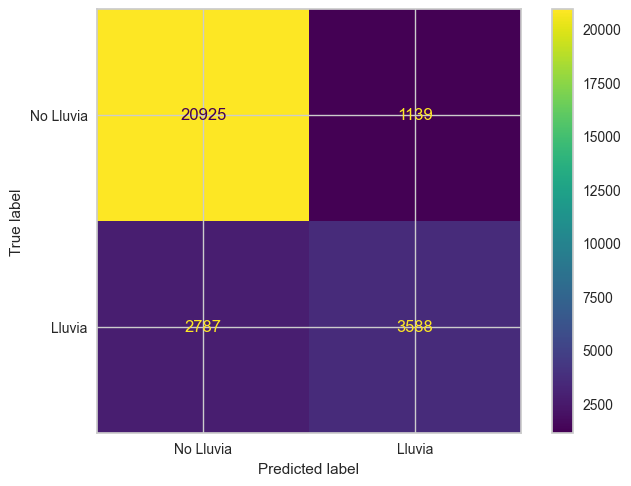

In [64]:
# Graficamos la matriz de confusión
y_pred_autoML = predictions['prediction_label']    # "prediction_label" es la columna con las respuestas del modelo.

cm = confusion_matrix(y_test, y_pred_autoML)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Lluvia', 'Lluvia'])
print("\nMatriz de Confusión del modelo PyCaret (sobre test_df):")
disp.plot()
plt.show()

El AutoML de PyCaret seleccionó LightGBM como el mejor modelo, destacando por su mayor AUC y F1-score frente a las demás alternativas. Este modelo ofrece un excelente equilibrio entre precisión y recall, mostrando buena capacidad de generalización y eficiencia en el manejo de variables numéricas y categóricas.

# **Redes Neuronales**

In [ ]:
class NeuralNetwork:
    # Ajustamos los hiperparámetros
    def __init__(self, epochs=100, batch_size=32, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self, input_shape):         # input_shape será el número de features que tenemos
        
        model = Sequential([
            # Capa de entrada
            Input(shape=(input_shape,)),

            # Capas ocultas 
            Dense(64, activation='relu'),
            Dropout(0.3),                       # Utilizamo Dropout para mitigar lo mas posible el Overfitting
            Dense(32, activation='relu'),
            Dropout(0.3),
            
            # Capa de Salida 
            Dense(1, activation='sigmoid')      # Utilizamos 'sigmoid' para darnos una probabilidad de 0 a 1
        ])

        # Compilamos el modelo
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 
                tf.keras.metrics.AUC(name='auc'), # Agregamos métricas relevantes
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ])
        
        self.model = model
        self.model.summary()                      # Imprime un resumen de la arquitectura

    def train(self, X_train, y_train, X_valid, y_valid):
        # Usamos EarlyStopping para que el modelo deje de entrenar si no mejora en 'patience' épocas.
        early_stopping = EarlyStopping(
            monitor='val_auc',                    # Monitoreamos el AUC de validación
            patience=7,                           # Si no mejora en 7 épocas, para.
            mode='max',                           # Queremos maximizar el AUC
            restore_best_weights=True             # Guardamos el mejor modelo, no el último.
        )
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping],           # Pasamos el callback
            verbose=1
        )
        return history

    def evaluate(self, X_test, y_test):
        # Evaluamos el modelo en test
        print("\nEvaluación en Test Set:")
        results = self.model.evaluate(X_test, y_test)

        # Hacemos un print de los resultados
        for name, value in zip(self.model.metrics_names, results):
            print(f"{name}: {value:.4f}")
        return results

    def predict(self, X_new):
        # Devuelve las probabilidades (entre 0 y 1)
        return self.model.predict(X_new)

In [66]:
#Pasamos los datos de una matriz dispersa a una densa
X_train_dense = x_train_procesado.toarray()
X_test_dense = x_test_procesado.toarray()

    
# Creamos un set de validación para el EarlyStopping

# Basicamente volvemos a dividir los datos que teniamos de entrenamiento, sacrificando una parte de los mismos para que EarlyStopping
# tenga datos para comparar (los nuevos test) y saber cuando debe parar 
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_train_dense, 
    y_train_imp,                 # usamos y_train_imp ya que es una matriz de 0's y 1's
    test_size=0.2,               # 20% para validación
    random_state=42, 
    stratify=y_train             # Mantenemos la proporción de clases
)

print(f"Forma de X_train para NN: {X_train_nn.shape}")
print(f"Forma de y_train para NN: {y_train_nn.shape}")

Forma de X_train para NN: (91003, 121)
Forma de y_train para NN: (91003,)


In [67]:
# Instanciamos la Red
nn = NeuralNetwork(
    epochs=100,       # 100 como máximo, EarlyStopping hace que pare antes
    batch_size=64,
    learning_rate=0.001
)

# Construimos la arquitectura
# X_train_nn.shape[1] es el número de features de entrada
nn.build_model(input_shape=X_train_nn.shape[1])

# Entrenamos
history = nn.train(X_train_nn, y_train_nn, X_test_nn, y_test_nn)


# Evaluamos el rendimiento final en los datos de test
results = nn.evaluate(X_test_dense, y_test_imp)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7808      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9921 (38.75 KB)
Trainable params: 9921 (38.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


1422/14

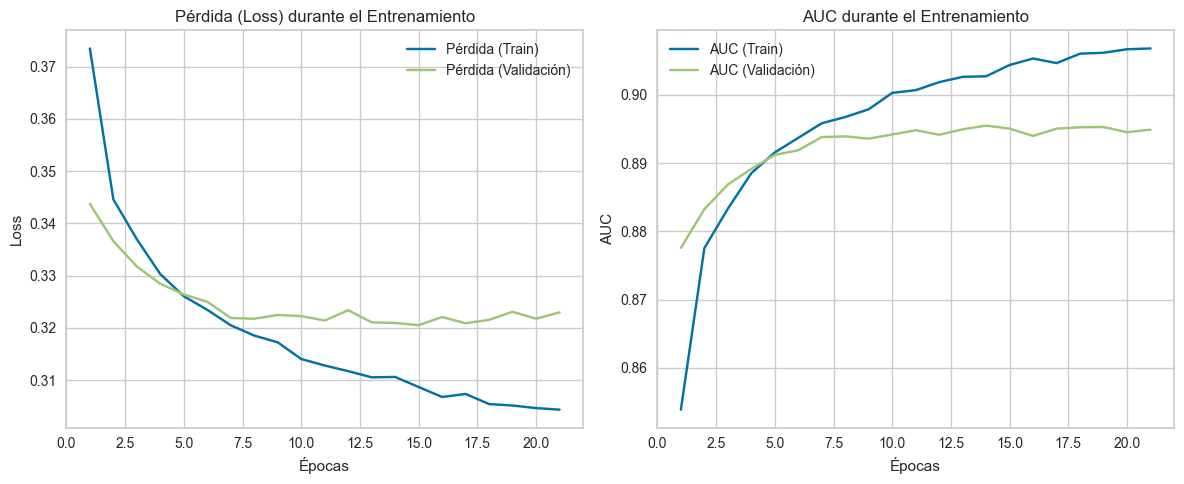

In [68]:
# Graficamos la Curva de Aprendizaje
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Pérdida (Train)')
plt.plot(epochs_range, val_loss, label='Pérdida (Validación)')
plt.title('Pérdida (Loss) durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Gráfico de AUC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, auc, label='AUC (Train)')
plt.plot(epochs_range, val_auc, label='AUC (Validación)')
plt.title('AUC durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

En las gráficas se observa que el modelo alcanza una pérdida menor y una **AUC** mayor en entrenamiento que en test, algo esperable en redes neuronales. Sin embargo, la brecha entre ambos conjuntos es reducida, por lo que no se evidencia un overfitting marcado.
En cuanto a métricas (la elegida que es e AUC), las redes neuronales son la mejor opción, seguidas de cerca por el AutoML.

### Optimización con Optuna

In [79]:
# Creamos la función que toma los hiperparámetros y construye la red neuronal.
def create_nn_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train_nn.shape[1],)))
    
    # Construimos las capas
    for i in range(params['n_layers']):
        model.add(Dense(params[f'n_units_layer{i}'], activation='relu'))
        model.add(Dropout(params[f'dropout_layer{i}']))
        
    model.add(Dense(1, activation='sigmoid')) # Salida binaria

    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model


# Función que Optuna llama en cada trial.
def objective(trial):
    
    # Sugerimos los parámetros
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.01, log=True),
        'n_layers': trial.suggest_int('n_layers', 1, 3)
    }
    
    # Sugerimos neuronas y dropout para cada capa
    for i in range(params['n_layers']):
        params[f'n_units_layer{i}'] = trial.suggest_int(f'n_units_layer{i}', 16, 128, log=True)
        params[f'dropout_layer{i}'] = trial.suggest_float(f'dropout_layer{i}', 0.1, 0.5)

    # Creamos y entrenamos el modelo
    model = create_nn_model(params)
    
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_test_nn, y_test_nn),
        epochs=20, # 20 épocas por "trial"
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_auc', patience=7, mode='max')],
        verbose=0 
    )
    
    #Devolver las métricas (AUC)
    val_auc = max(history.history['val_auc'])
    return val_auc


In [80]:
# Ejecutamos el estudio
study = optuna.create_study(direction='maximize') # Queremos maximizar el AUC
study.optimize(objective, n_trials=10, show_progress_bar=True) # 10 intentos

# Obtenemos el mejor modelo y lo reentrenamos
best_nn_params = study.best_params

print("Mejores hiperparámetros encontrados:")
print(best_nn_params)

# Creamos el modelo final
best_nn_model = create_nn_model(best_nn_params)

X_train_nn_opti = X_train_nn.copy()
y_train_nn_opti = y_train_nn.copy()
X_test_nn_opti = X_test_nn.copy()
y_test_nn_opti = y_test_nn.copy()


# Lo reentrenamos con EarlyStopping
history = best_nn_model.fit(
    X_train_nn_opti, y_train_nn_opti,
    validation_data=(X_test_nn_opti, y_test_nn_opti),
    epochs=100,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)],
    verbose=1
)

# Usamos el modelo optimizado para predecir sobre el test denso
y_pred_proba_nn = best_nn_model.predict(X_test_dense).flatten()     # .flatten() lo convierte de un array 2D a 1D, más fácil de usar
threshold = 0.5
y_pred_nn = (y_pred_proba_nn > threshold).astype(int)

[I 2025-11-23 18:48:02,716] A new study created in memory with name: no-name-74588b99-5ae1-4afd-80e3-5f3898315573


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-11-23 18:49:02,216] Trial 0 finished with value: 0.8947022557258606 and parameters: {'learning_rate': 0.0028278871270702695, 'n_layers': 2, 'n_units_layer0': 74, 'dropout_layer0': 0.3886809432471968, 'n_units_layer1': 113, 'dropout_layer1': 0.3155333860920536}. Best is trial 0 with value: 0.8947022557258606.
[I 2025-11-23 18:50:01,515] Trial 1 finished with value: 0.8947959542274475 and parameters: {'learning_rate': 0.0018027887252066437, 'n_layers': 3, 'n_units_layer0': 43, 'dropout_layer0': 0.3767309774286428, 'n_units_layer1': 73, 'dropout_layer1': 0.4092664815850581, 'n_units_layer2': 20, 'dropout_layer2': 0.354266953241103}. Best is trial 1 with value: 0.8947959542274475.
[I 2025-11-23 18:50:44,592] Trial 2 finished with value: 0.894766092300415 and parameters: {'learning_rate': 0.004712848090112274, 'n_layers': 1, 'n_units_layer0': 40, 'dropout_layer0': 0.15859702803904333}. Best is trial 1 with value: 0.8947959542274475.
[I 2025-11-23 18:51:51,150] Trial 3 finished with 

              precision    recall  f1-score   support

   No Lluvia       0.88      0.96      0.92     22064
      Lluvia       0.79      0.53      0.64      6375

    accuracy                           0.86     28439
   macro avg       0.83      0.75      0.78     28439
weighted avg       0.86      0.86      0.85     28439

Matriz de Confusión (Red Neuronal) 


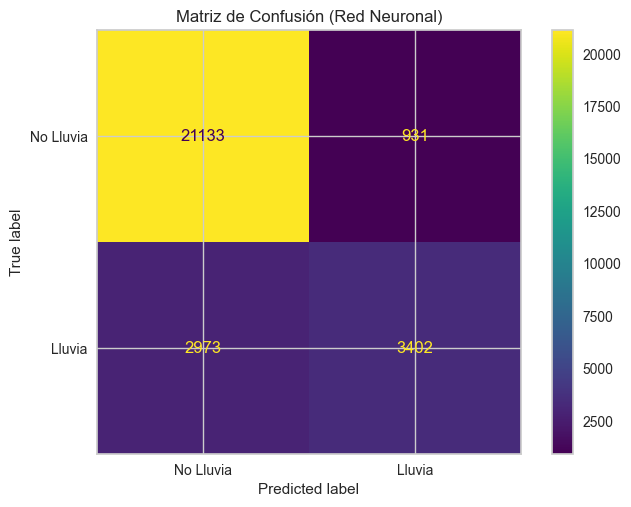

Curva ROC (Red Neuronal) 


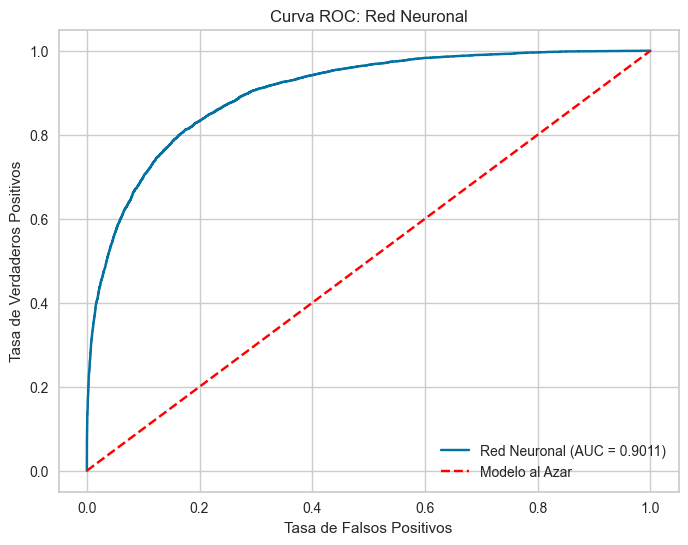

In [71]:
# Informe de Clasificación 
print(classification_report(y_test_imp, y_pred_nn, target_names=['No Lluvia', 'Lluvia']))

# Matriz de Confusión 
print("Matriz de Confusión (Red Neuronal) ")
cm = confusion_matrix(y_test_imp, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Lluvia', 'Lluvia'])
disp.plot()
plt.title("Matriz de Confusión (Red Neuronal)")
plt.show()

# Curva ROC y AUC 
# (Usamos las probabilidades 'y_pred_proba_nn')
auc_nn = roc_auc_score(y_test_imp, y_pred_proba_nn)
fpr, tpr, _ = roc_curve(y_test_imp, y_pred_proba_nn)

#Graficamos
print("Curva ROC (Red Neuronal) ")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Red Neuronal (AUC = {auc_nn:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Modelo al Azar')
plt.title('Curva ROC: Red Neuronal')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid(True)
plt.show()

### SHAP

In [ ]:
# Definimos un background para que SHAP compare y calcule cuánto aleja cada variable a la predicción respecto al promedio.
background = shap.sample(X_train_dense, 50)       #Usamos solo 50 filas para que shap entienda lo qe hace el modelo sin set muy pesado

# Usamos 30 filas de test para explicar
X_test_sample = shap.sample(X_test_dense, 30)

#Creamos el explicador
explainer = shap.KernelExplainer(best_nn_model.predict, background) # KernelExplainer trata al modelo como una "caja negra" 

# Calculamos valores SHAP
shap_values_nn = explainer.shap_values(X_test_sample)

# Ajustamos el formato, necesitamos asegurarnos de que sea un array 2D

# Sacamos el primer elemento
shap_values_nn = shap_values_nn[0]


2/2 [==============================] - 0s 0s/step


  0%|          | 0/30 [00:00<?, ?it/s]

3488/3488 [==============================] - 4s 1ms/step


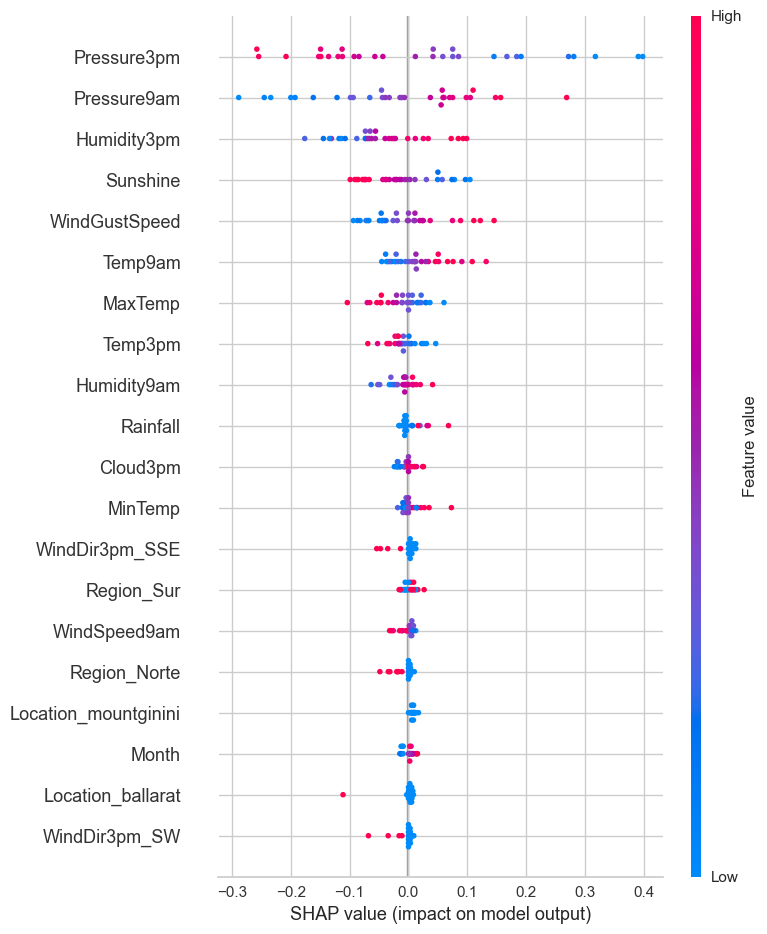

In [85]:
#Gáfico de puntos
shap.summary_plot(
    shap_values_nn, 
    X_test_sample, 
    feature_names=all_feature_names
)
plt.show()

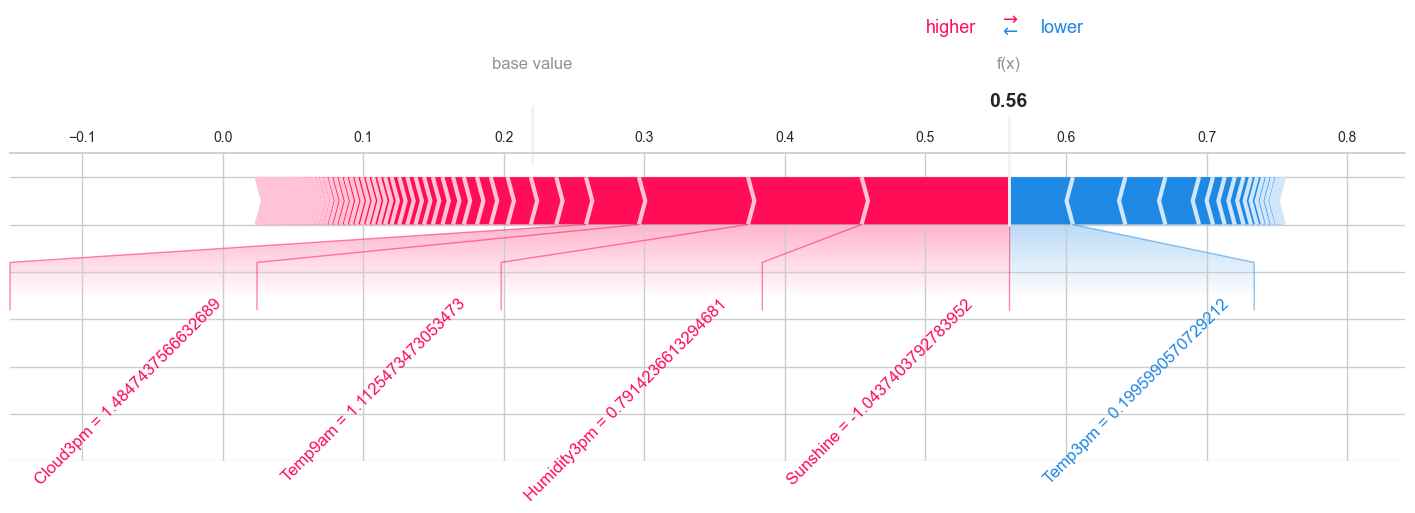

In [ ]:
# Creamos el dataframe solo para estas 20 filas para tener los nombres
test_sample_df = pd.DataFrame(X_test_sample, columns=all_feature_names)

# Usamos 'shap.force_plot'
shap.force_plot(
    explainer.expected_value,   # El valor base (promedio)
    shap_values_nn[1],          # Los valores SHAP de ESTA instancia
    test_sample_df.iloc[1],     # Los datos de ESTA instancia 
    matplotlib=True,            # Para que se vea estático
    figsize=(18, 4),
    text_rotation=45
)
plt.show()

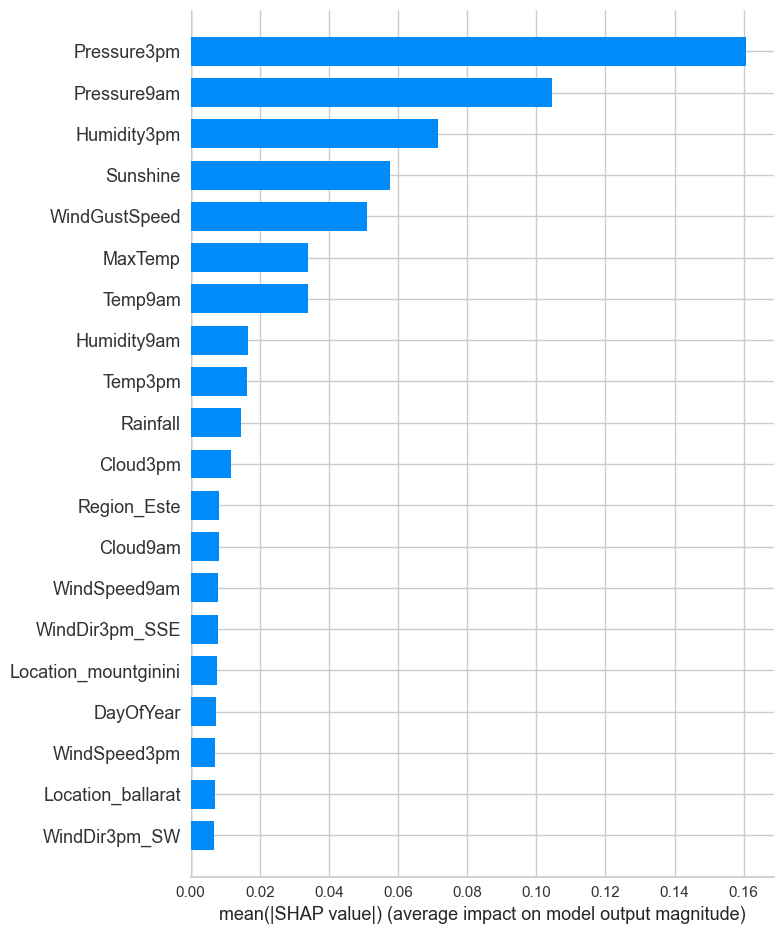

In [75]:
# Bar Plot 
shap.summary_plot(
    shap_values_nn, 
    X_test_sample, 
    plot_type="bar", 
    feature_names=all_feature_names
)
plt.show()

Con la explicacion de los modelos SHAP, vemos que las Redes neuronales le dan más importancia a otros datos, por ejemplo le dan mas importancia a las presiones, la cantidad de horas de sol, etc.

# **Comparación de modelos**

Para la comparacion de los modelos, nos vamos a enfocar en las graficas de las curvas ROC, las matrices de confusion y la métrica que más nos interesa, el AUC:

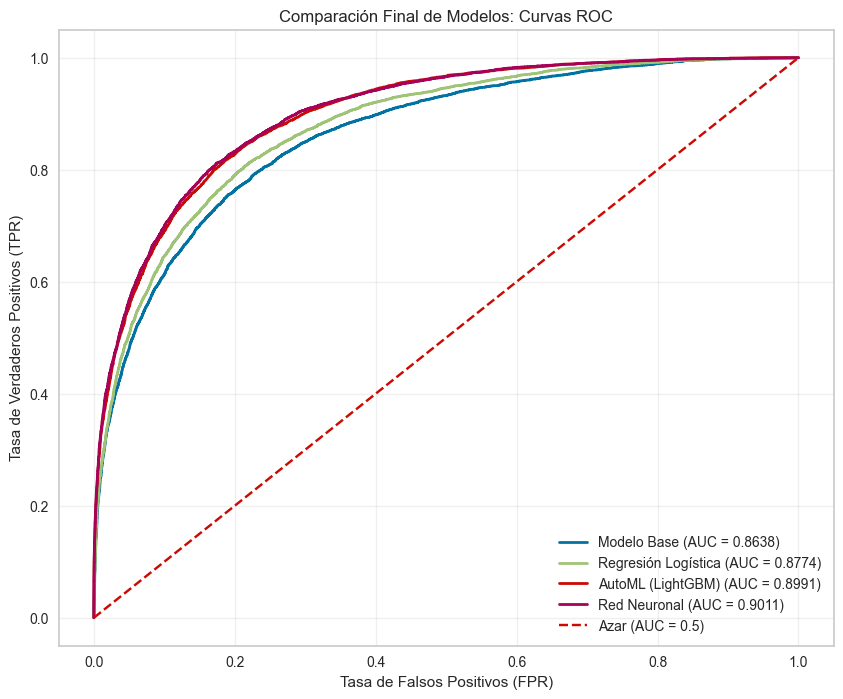

                Modelo       AUC
3         Red Neuronal  0.901138
2    AutoML (LightGBM)  0.899080
1  Regresión Logística  0.877449
0          Modelo Base  0.863827


In [78]:
#Aplicamos un LabelEncoder
le = LabelEncoder()
y_test_numeric = le.fit_transform(y_test)

# Recopilamos las probabilidades

#  Modelo Base
probs_base = y_pred_proba_base 

# Regresión Logística 
probs_logreg = y_proba_ajustado

# AutoML (PyCaret)
probs_automl = predictions['prediction_score_Yes']

# Redes Neuronales
probs_nn = y_pred_proba_nn


# Creamos un diccionario de Modelos
modelos = {
    'Modelo Base': probs_base,
    'Regresión Logística': probs_logreg,
    'AutoML (LightGBM)': probs_automl,
    'Red Neuronal': probs_nn
}

resultados = []

# Graficaso y calculamos el AUC
plt.figure(figsize=(10, 8))

for nombre, probs in modelos.items():
    # Calculamos AUC
    auc = roc_auc_score(y_test_numeric, probs) 
    
    # Calculamos curva ROC
    fpr, tpr, _ = roc_curve(y_test_numeric, probs) 
    
    # Guardamos para la tabla
    resultados.append({'Modelo': nombre, 'AUC': auc})
    
    # Graficamos curva
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.4f})', linewidth=2)

# Detalles del gráfico
plt.plot([0, 1], [0, 1], 'r--', label='Azar (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación Final de Modelos: Curvas ROC')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


# Tabla de Posiciones
df_resultados = pd.DataFrame(resultados).sort_values(by='AUC', ascending=False)
print(df_resultados)

Basándonos en la métrica seleccionada (AUC), el mejor modelo para predecir la lluvia es la Red Neuronal, alcanzando un AUC de 0.9020.

**Red Neuronal (0.90)**: Logró superar a todos los demás modelos, demostrando que pudo capturar patrones complejos en los datos que el resto de modelos no vieron.

**AutoML - LightGBM (0.89)**: Quedó en un segundo puesto. Esto valida que los modelos de AutoML son potentes, logrando un rendimiento casi idéntico al de una red neuronal.

**Regresión Logística (0.87)**: A pesar de ser un modelo lineal y más simple, tuvo métricas razonables.

**Modelo Base (0.86)**: Fue el de menor rendimiento, como se esperaba al haber eliminado variables, pero sirvió como punto de referencia.

Decisión: Seleccionamos la **Red Neuronal** como el modelo final para producción.

# **MLOps**

Procedemos a guardar los archivos de las redes neuronales, tanto el preprocesador como el mejor modelo optimizado por Optuna

In [88]:
# Guardamos el Preprocesador 
joblib.dump(preprocessor, 'preprocessor.joblib')

# Guardamos la Red Neuronal 
best_nn_model.save('best_model.keras')

# **CONCLUSIÓN FINAL**

## Conclusión General del Trabajo Práctico: Predicción de Lluvia en Australia

### **1. Introducción y Preprocesamiento de Datos**

El objetivo principal fue desarrollar un modelo de clasificación capaz de predecir si lloverá al día siguiente en Australia. El proyecto comenzó con un fuerte enfoque en la ingeniería de características y la calidad de los datos:

Clusterización Geográfica: Se implementó un algoritmo de K-Means para agrupar las ciudades en regiones climáticas. Esto permitió simplificar la variable 'Location', capturando patrones regionales (como la diferencia entre zonas costeras y desérticas) sin la alta variabilidad de usar cada ciudad individualmente.

Manejo de Datos Faltantes: Nos enfrentamos a un dataset con un alto porcentaje de valores nulos en variables clave como 'Sunshine' y 'Cloud3pm'. Se comparó una imputación simple (mediana) contra una imputación iterativa (IterativeImputer). Se optó por la segunda, ya que demostró preservar mejor la distribución natural de los datos y las correlaciones entre variables, evitando los "picos artificiales" que generaba la imputación simple.

Desafíos de Memoria (RAM): Uno de los mayores obstáculos técnicos fue el One-Hot Encoding de la columna 'Date', que generó una explosión en la dimensionalidad (más de 3000 columnas), agotando la memoria RAM. Esto se resolvió mediante Feature Engineering, transformando la fecha en variables numéricas cíclicas (Month, DayOfYear) y eliminando la fecha original, además de utilizar matrices dispersas (sparse_output=True) en el pre-procesamiento.

### **2. Modelado y Estrategia Base**

Se estableció un modelo base utilizando Regresión Logística.

Balanceo de Clases: Dado el desbalance del dataset (más días "No Lluvia" que "Lluvia"), la métrica de Accuracy fue descartada como indicador principal. Se utilizó el parámetro class_weight='balanced', lo cual resultó ser una decisión crítica que elevó el rendimiento del modelo lineal.

Optimización de Hiperparámetros: Se aplicó RandomizedSearchCV para intentar mejorar la Regresión Logística. Curiosamente, los resultados mostraron que el modelo original ya era óptimo. La optimización no logró superar el AUC del modelo original, demostrando que la limitación no eran los hiperparámetros, sino la linealidad del modelo ante un problema complejo.

### **3. Modelos Avanzados: AutoML y Redes Neuronales**

Para superar el límite de la Regresión Logística, exploramos arquitecturas no lineales:

AutoML (PyCaret - LightGBM): Al implementar un modelo de AutoML vimos que el mejor tipo era lightGBM, el cual llevo las métricas a un nivel superior de lo que eran con los modelos más simples, aunque lejos de las futuras Redes neuronales.

Redes Neuronales: Se diseñó una arquitectura de red neuronal densa con capas de Dropout para regularización y EarlyStopping para evitar overfitting. Este modelo demostró ser superior al capturar las no-linealidades de las variables.

### **4. Explicabilidad (SHAP)**

Para evitar que la Red Neuronal fuera una "caja negra", aplicamos SHAP (SHapley Additive exPlanations). El análisis reveló que el modelo sigue una lógica meteorológica coherente:

Las variables más influyentes fueron Pressure3pm (Presión baja → Lluvia), Humidity3pm (Humedad alta → Lluvia) y WindGustSpeed.

Esto valida que el modelo no está memorizando ruido, sino aprendiendo física atmosférica básica.

### **5. Comparación Final y Selección**

Se utilizó el AUC-ROC como métrica unificadora para la comparación, debido a su robustez frente al desbalance y su independencia del umbral de decisión. En la comparación vimos el poder del AutML siendo un modelo muy potente al punto de casi igualar las métricas de la red neuronal, pero esta última fue la elegida como el mejor modelo.

### **6. Docker (MLOps)**

Como paso final, el modelo ganador (Red Neuronal) y el pipeline de preprocesamiento fueron serializados y encapsulados en un contenedor Docker. Esto asegura la reproducibilidad del entorno y permite que el modelo sea ejecutado de manera agnóstica a la plataforma, listo para realizar inferencias diarias de predicción de lluvia.

### **Conclusión Final**

El trabajo práctico demostró que, si bien un modelo lineal bien ajustado puede ofrecer un rendimiento muy decente, la complejidad de los fenómenos climáticos se beneficia significativamente de modelos no lineales. La Red Neuronal seleccionada ofrece el mejor equilibrio entre precisión y robustez, validada no solo por sus métricas, sino también por su interpretabilidad física a través de SHAP.